###Install Packages

In [ ]:
import numpy as np
!pip install scikit-learn==1.3.0
import os
import matplotlib.pyplot as plt
from pathlib import *
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install tensorflow-addons --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

###Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


###Constants

In [ ]:
# DIRECTORIES
CURRENT_PATH = "/content/drive/My Drive/max_sinus6"

# DATASET_PATH = "dataset"
DATASET_PATH = "/content/drive/My Drive/max_sinus6"
DATASET_TRAIN = "train"
DATASET_VAL = "val"
DATASET_TEST = "test"

# Directory structure for Train, Validation and Test dataset
DIR_NAMES = {
    "clear": "clear",
    "opaque": "opaque",
    "thick": "thick"
}

# Number of Classes
NUM_CLASSES = 3
# Classes
CLASSES = {
    "clear":0,
    "opaque":1,
    "thick":2
}

BALANCE_DATASET = False


# IMAGE CONFIG
CHANNELS = 3
IMG_SIZE = (200, 200)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)

# HYPER PARAMETERS (VIT)
BATCH_SIZE = 32
NUM_EPOCHS = 200
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

PATCH_SIZE = 20
NUM_PATCHES = (IMG_SIZE[0] // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM
]
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]

## MLP
EMBEDDING_DIM = 256
NUM_BLOCKS = 4
DROPOUT_RATE = 0.2

###Paths

In [ ]:
TRAIN_PATHS = list()
VAL_PATHS = list()
TEST_PATHS = list()
PATHS_CLASS = list()

In [ ]:
for class_name, name in DIR_NAMES.items():
    TRAIN_PATHS.append(os.path.join(CURRENT_PATH, DATASET_PATH, DATASET_TRAIN, name))
    VAL_PATHS.append(os.path.join(CURRENT_PATH, DATASET_PATH, DATASET_VAL, name))
    TEST_PATHS.append(os.path.join(CURRENT_PATH, DATASET_PATH, DATASET_TEST, name))
    PATHS_CLASS.append(class_name)

###Array of filenames along with absolute path

In [ ]:
# train dataset
x_train_temp = list()
x_train = list()
y_train = list()

# validation dataset
x_val_temp = list()
x_val = list()
y_val = list()

# test dataset
x_test_temp = list()
x_test = list()
y_test = list()

In [ ]:
for class_name, name in DIR_NAMES.items():
    index = PATHS_CLASS.index(class_name)
    class_id = CLASSES[class_name]
    train_filenames = [os.path.join(TRAIN_PATHS[index], filename) for filename in os.listdir(TRAIN_PATHS[index])]
    x_train_temp.append(train_filenames)

    val_filenames = [os.path.join(VAL_PATHS[index], filename) for filename in os.listdir(VAL_PATHS[index])]
    x_val_temp.append(val_filenames)

    test_filenames = [os.path.join(TEST_PATHS[index], filename) for filename in os.listdir(TEST_PATHS[index])]
    x_test_temp.append(test_filenames)


###Image count & classes

In [ ]:
print("CLASS\tTRAIN\tVAL\tTEST")
for i in range(NUM_CLASSES):
    print(f"{PATHS_CLASS[i]}\t{len(x_train_temp[i])}\t{len(x_val_temp[i])}\t{len(x_test_temp[i])}")

###Function to map class names to numerical identifiers

In [ ]:
def get_y(class_name):
    return CLASSES[class_name]

In [ ]:
def get_class_from_index(index: int):
    for class_name, value in CLASSES.items():
        if value == index:
            return class_name

In [ ]:
get_class_from_index(0), get_class_from_index(1), get_class_from_index(2)

###Open one image

In [ ]:
def preprocess_image(filename):
    image_str = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_str, channels=CHANNELS)
    image = tf.image.resize(image, IMG_SIZE)
    return image

In [ ]:
def get_image(filename):
    img = preprocess_image(filename)
    return tf.keras.preprocessing.image.array_to_img(img)

In [ ]:
t_name = x_train_temp[0][0]
img = preprocess_image(t_name)
plt.imshow(tf.keras.preprocessing.image.array_to_img(img))

###Initializing arrays for training, validation, and testing datasets

In [ ]:
# train
x_train = np.array([])
y_train = np.array([])

# val
x_val = np.array([])
y_val = np.array([])

# test
x_test = np.array([])
y_test = np.array([])

###Creating the input and output

In [ ]:
def concat_dataset(arr, dataset, init):
    if init:
        arr = np.array([ preprocess_image(filename) for filename in dataset ])
        arr = arr/255.0
    else:
        temp = np.array( [preprocess_image(filename) for filename in dataset] )
        temp = temp/255.0
        arr = np.concatenate( ( arr,  temp) )
    return arr

In [ ]:
for i in range(len(x_train_temp)):
    class_name = PATHS_CLASS[i]
    y = get_y(class_name)

    # train
    train_total = len(x_train_temp[i])
    print(train_total, y)
    y_train = np.concatenate( ( y_train, np.full((train_total), y) ) )
    x_train = concat_dataset(x_train, x_train_temp[i], i == 0)

    # val
    val_total = len(x_val_temp[i])
    y_val = np.concatenate( ( y_val, np.full((val_total), y) ) )
    x_val = concat_dataset(x_val, x_val_temp[i], i == 0)

    # test
    test_total = len(x_test_temp[i])
    y_test = np.concatenate( ( y_test, np.full((test_total), y) ) )
    x_test = concat_dataset(x_test, x_test_temp[i], i == 0)

275 0
275 1
275 2


In [ ]:
len(x_train), len(x_val), len(x_test)

(825, 165, 108)

###Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(*IMG_SIZE),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
             height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation"
)

In [ ]:
data_augmentation.layers[0].adapt(x_train)

In [ ]:
len(x_train_temp[2]), len(x_train[10:]), len(y_train)

(275, 815, 825)

### 11. ViT Classifier

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 200 X 200
Patch size: 20 X 20
Patches per image: 100
Elements per patch: 1200


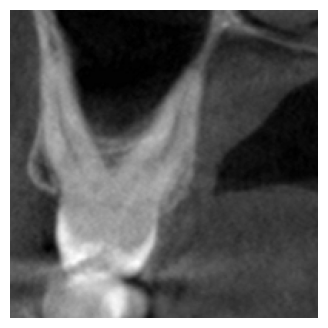

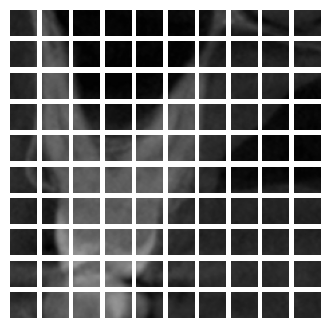

In [ ]:
import matplotlib.pyplot as plt

random_index = np.random.choice(range(len(x_train_temp[0])))
image_file_name = x_train_temp[0][random_index]

plt.figure(figsize=(4, 4))
image = preprocess_image(image_file_name)
plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=IMG_SIZE
)
patches = Patches(PATCH_SIZE)(resized_image)
print(f"Image size: {IMG_SIZE[0]} X {IMG_SIZE[0]}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, CHANNELS))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_model():
    inputs = layers.Input(shape=INPUT_SHAPE)
    augmented = data_augmentation(inputs)
    patches = Patches(PATCH_SIZE)(augmented)
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    # ATTENTION
    attention_scores = {}
    index = 0
    for _ in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_layer = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )
        attention_output, attention_score = attention_layer(x1, x1, return_attention_scores=True)

        attention_scores[f'layer_{index+1}'] = attention_score
        index += 1

        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=TRANFORMER_UNITS, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    logits = layers.Dense(NUM_CLASSES)(features)
    model = keras.Model(inputs=inputs, outputs=[logits, attention_scores])
    return model

In [ ]:
def create_training_model(vit_model):
    logits, attention_scores = vit_model.output
    training_model = keras.Model(inputs=vit_model.input, outputs=logits)
    return training_model

In [ ]:
def run_experiment(p_model, load_model=False):
    model = create_training_model(p_model)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),]
    )

    history=None
    if load_model==False:
      history = model.fit(
          x=x_train,
          y=y_train,
          batch_size=BATCH_SIZE,
          epochs=200,
          validation_data=(x_val, y_val),
      )

    if load_model:
      vit_model_weights = '/content/drive/MyDrive/vit_model_sinus.weights.h5'
      model.load_weights(vit_model_weights)

    model.evaluate(x_test, y_test)
    return history, model, p_model

###Load saved ViT model

In [ ]:
vit_model_weights = '/content/drive/MyDrive/vit_model_sinus.weights.h5'

### 13. Training

In [ ]:
vit_model = create_vit_model()
history, vit_model, t_model = run_experiment(vit_model, True)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 280 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - accuracy: 0.9644 - loss: 0.1977


###Model Summary

In [ ]:
vit_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 200, 200, 3)    │              7 │ input_layer[0][0]      │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_1 (Patches)       │ (None, None, 1200)     │              0 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 100, 64)        │         83,264 │ patches_1[0][0]        │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 100, 64)        │            128 │ patch_encoder[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ [(None, 100, 64),      │         66,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │ (None, 4, 100, 100)]   │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 100, 64)        │              0 │ multi_head_attention[… │
│                           │                        │                │ patch_encoder[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 100, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100, 128)       │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 100, 128)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 100, 64)        │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 100, 64)        │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 100, 64)        │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 100, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ [(None, 100, 64),      │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │ (None, 4, 100, 100)]   │                │ layer_normalization_2… │
├──────────────────────

 Total params: 15,959,498 (60.88 MB)

 Trainable params: 15,959,491 (60.88 MB)

 Non-trainable params: 7 (32.00 B)

###Uncertainty Estimation

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from scipy.special import softmax

import matplotlib.cm as cm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from scipy.stats import entropy
from tensorflow.image import resize

###Section 1

###1. Calculation of mean and variance

In [ ]:
class_labels = ['clear', 'opaque', 'thick']
def predict_with_uncertainty(model, x, n_iter=100):
    predictions = np.zeros((n_iter, x.shape[0], NUM_CLASSES))

    for i in range(n_iter):
        predictions[i] = model(x, training=True).numpy()

    prediction_mean = np.mean(predictions, axis=0)
    prediction_variance = np.var(predictions, axis=0)

    return prediction_mean, prediction_variance

In [ ]:
# With test dataset
mean_predictions, prediction_variance = predict_with_uncertainty(vit_model, x_test, n_iter=100)
for i in range(len(x_test)):
    print(f"Sample {i}:")
    print(f"Mean prediction: {mean_predictions[i]}")
    print(f"Prediction variance (epistemic uncertainty): {prediction_variance[i]}")

Sample 0:
Mean prediction: [ 10.48735792 -19.0296081   -1.62527281]
Prediction variance (epistemic uncertainty): [ 34.56518627 123.3069053   15.28114984]
Sample 1:
Mean prediction: [ 22.90253147 -35.14559703  -3.48777778]
Prediction variance (epistemic uncertainty): [ 70.92176497 135.61110258  40.47779458]
Sample 2:
Mean prediction: [ 16.42384899 -28.80122355  -3.83017827]
Prediction variance (epistemic uncertainty): [33.95871965 98.55752642 13.66300898]
Sample 3:
Mean prediction: [ 18.52776329 -28.76389345  -4.41163197]
Prediction variance (epistemic uncertainty): [ 64.47940516 116.12466237  20.95864145]
Sample 4:
Mean prediction: [ 22.26211334 -31.81029547  -4.00755171]
Prediction variance (epistemic uncertainty): [ 80.65185449 158.29161463  25.72329353]
Sample 5:
Mean prediction: [ 22.8664375  -39.25227171  -6.48291542]
Prediction variance (epistemic uncertainty): [ 63.80385556 129.88610411  33.28762263]
Sample 6:
Mean prediction: [ 14.47317418 -24.38482092  -2.71181035]
Prediction 

###2. Conversion to probabilities

In [ ]:
mean_predictions = np.array([
  [ 10.48735792, -19.0296081, -1.62527281],
  [ 22.90253147, -35.14559703, -3.48777778],
  [ 16.42384899, -28.80122355, -3.83017827],
  [ 18.52776329, -28.76389345, -4.41163197],
  [ 22.26211334, -31.81029547, -4.00755171],
  [ 22.8664375, -39.25227171, -6.48291542],
  [ 14.47317418, -24.38482092, -2.71181035],
  [ 9.27663434, -15.60461887, -0.16281739],
  [ 17.25832857, -26.45030126, -5.07740643],
  [ 9.70701659, -15.70897002, -1.58740577],
  [ 3.82715429, -7.67672102, 1.6677492],
  [ 18.74221197, -33.81630148, -3.25429072],
  [ 18.64996504, -29.64333511, -4.32581159],
  [ 4.21081163, -7.6045306, 0.86052457],
  [ 4.07424665, -7.88395432, 2.22907428],
  [ 14.61482114, -26.1820436, -3.79776623],
  [ 12.39260797, -20.84976193, -2.54484785],
  [ 6.51484803, -11.04554536, 1.802309],
  [ 8.39019186, -12.81896084, -0.28832577],
  [ 24.36054348, -39.52096826, -7.96142658],
  [ 11.79519076, -19.46480939, -0.56002723],
  [ 11.1043672, -19.06931277, -0.44709595],
  [ 12.66776899, -22.98857273, -1.81394342],
  [ 15.40801175, -28.05049591, -3.38958927],
  [ 4.96701774, -8.56206249, 1.42429876],
  [ 6.74405235, -10.99843306, 3.95555666],
  [ 1.02848985, -2.98371864, 4.29250223],
  [ 12.03217456, -21.57503106, -1.61646487],
  [ 14.84949187, -28.33388987, -3.31349748],
  [ 21.05433088, -34.38553734, -5.9517898],
  [ 15.65324176, -28.23711218, -3.83266573],
  [ 14.30209032, -21.53991961, -3.03138002],
  [ 15.98710176, -27.25570065, -4.15339256],
  [ 13.47234442, -24.43850883, -2.56548785],
  [ 18.771284, -28.47222459, -3.48248131],
  [ 10.38467684, -15.25481362, -2.18971313],
  [-20.38355039, 23.98049282, 1.82062182],
  [-15.53291371, 17.73776503, 3.00793927],
  [-29.69610387, 29.93409237, -0.67588721],
  [-34.78618741, 41.05790792, -1.24191721],
  [-48.03385149, 56.54973537, -1.99525498],
  [-41.1584112, 50.16090549, -0.21292216],
  [-46.08169149, 54.00955307, 0.85152365],
  [-41.73054617, 47.7771208, -0.07839607],
  [-39.53257745, 47.08529882, -1.04502074],
  [-33.48415055, 38.30909013, -0.61330783],
  [-34.01383615, 38.81056118, 0.79354214],
  [-32.69884733, 35.87152225, 2.52926066],
  [-23.91515387, 30.42226249, 1.47247722],
  [-39.69358189, 47.58594178, 0.15434847],
  [-28.35757427, 35.03344373, 1.39139996],
  [-35.51644326, 41.10686289, -0.73934766],
  [-3.19556498e+01, 3.76365511e+01, 1.67291264e-02],
  [-4.04879366e+01, 4.68172820e+01, 5.22507310e-03],
  [-27.23018343, 32.52447239, -0.30878854],
  [-35.63657656, 41.34870774, -1.84180417],
  [-5.48487411, 1.29875995, 9.31873551],
  [-26.60556897, 31.21854229, 2.20477144],
  [-27.77744372, 33.11583131, 1.04205964],
  [-19.5408951, 21.84308548, 3.03779654],
  [-43.13637241, 49.64072044, -1.99877106],
  [-13.76610594, 15.795254, 3.13360349],
  [-24.89886217, 31.34922349, 0.28172303],
  [-6.00590125, 4.67985696, 2.78129866],
  [-31.2638288, 38.53031643, 0.9001023],
  [-42.63409146, 50.56302029, -1.00695404],
  [-34.44447739, 40.33201686, -1.93082419],
  [-35.67153589, 41.95323038, -1.69277553],
  [-24.60201614, 29.98417738, -0.58893183],
  [-42.98384678, 48.81322441, 2.24903762],
  [-37.9988651, 43.8921773, -1.71988624],
  [-26.39876616, 30.25838863, -0.08635541],
  [-6.66508941, -4.67114032, 17.99025011],
  [-8.70491123, -1.2204274, 16.68022522],
  [-6.43973514, 4.81954396, 3.18760226],
  [-6.29502697, -0.60842884, 12.31443926],
  [-4.23946485, -2.3114497, 10.29829066],
  [-3.32739106, -7.27445092, 22.87678187],
  [-6.60290765, -0.94912054, 27.89179159],
  [-3.57652681, -1.24387457, 12.55745689],
  [ 1.8206274, -10.33599191, 33.50790008],
  [-2.5141118, -3.63278222, 15.26063601],
  [-4.80641277, 0.50651226, 14.83042905],
  [-2.01933878, -4.47477127, 9.88967543],
  [-3.27633964, -0.65178344, 8.2448818],
  [-6.0423473, -3.23470853, 21.26395724],
  [-8.72538959, -3.72101647, 21.68564822],
  [-3.16110933, -1.23991251, 11.50505443],
  [-4.10483499, -0.02037551, 9.3250168],
  [-6.22555527, 3.09097611, 9.43646175],
  [ 1.10702894, -5.39758017, 6.91018496],
  [-10.5187645, 6.73814962, 11.87879723],
  [-8.86829324, 4.35729842, 1.94603077],
  [-3.54334581, -5.39905799, 22.92109571],
  [-4.47395597, -2.13023977, 12.31865836],
  [-0.09375894, -8.54728912, 25.24845562],
  [-10.03270904, 1.25381738, 24.27536152],
  [-3.38581363, 0.0110544, 7.79921023],
  [-2.61567717, -1.49333912, 12.43184043],
  [-3.82123919, -3.68978925, 23.69695631],
  [-2.84468845, -3.90509362, 18.64828763],
  [-5.33179364, -1.91367967, 14.70084029],
  [-4.48981111, -1.97918431, 21.70142891],
  [-5.0551976, -3.40063075, 10.76649142],
  [-5.44401218, 1.22156437, 14.04500796],
  [-4.11362447, -1.85308092, 13.18076608],
  [-5.53822647, 1.71991108, 12.00355949],
  [-4.56455175, -6.08780214, 22.74813673],
])

In [ ]:
probabilities = tf.nn.softmax(mean_predictions, axis=1).numpy()
for i, prob in enumerate(probabilities):
    print(f"Sample {i}:")
    print(f"Logits: {mean_predictions[i]}")
    print(f"Probabilities: {prob}")

Sample 0:
Logits: [ 10.48735792 -19.0296081   -1.62527281]
Probabilities: [9.99994510e-01 1.51684831e-13 5.48970400e-06]
Sample 1:
Logits: [ 22.90253147 -35.14559703  -3.48777778]
Probabilities: [1.00000000e+00 6.16620711e-26 3.45807427e-12]
Sample 2:
Logits: [ 16.42384899 -28.80122355  -3.83017827]
Probabilities: [9.99999998e-01 2.28560171e-20 1.59877638e-09]
Sample 3:
Logits: [ 18.52776329 -28.76389345  -4.41163197]
Probabilities: [1.00000000e+00 2.89397275e-21 1.09030303e-10]
Sample 4:
Logits: [ 22.26211334 -31.81029547  -4.00755171]
Probabilities: [1.00000000e+00 3.28587646e-24 3.90148038e-12]
Sample 5:
Logits: [ 22.8664375  -39.25227171  -6.48291542]
Probabilities: [1.00000000e+00 1.05241582e-27 1.79365115e-13]
Sample 6:
Logits: [ 14.47317418 -24.38482092  -2.71181035]
Probabilities: [9.99999966e-01 1.33102783e-17 3.44077308e-08]
Sample 7:
Logits: [  9.27663434 -15.60461887  -0.16281739]
Probabilities: [9.99920482e-01 1.56377582e-11 7.95176737e-05]
Sample 8:
Logits: [ 17.25832857 

###3. Plotting of uncertainty

In [ ]:
prediction_variance = np.array([
  [ 34.56518627, 123.3069053, 15.28114984],
  [ 70.92176497, 135.61110258, 40.47779458],
  [33.95871965, 98.55752642, 13.66300898],
  [ 64.47940516, 116.12466237, 20.95864145],
  [ 80.65185449, 158.29161463, 25.72329353],
  [ 63.80385556, 129.88610411, 33.28762263],
  [ 66.58396086, 179.77852915, 22.82684212],
  [34.78967486, 98.06924515, 15.24439794],
  [38.74034439, 75.70217781, 20.92614769],
  [52.47281279, 92.86527116, 19.51306512],
  [18.32205491, 51.12198633, 6.94224079],
  [ 47.02959585, 140.73555797, 21.42091673],
  [ 42.24989617, 119.93665384, 29.89544481],
  [19.05724288, 29.12274897, 10.25859722],
  [12.4376545, 21.88583072, 8.85866723],
  [28.83890072, 69.10604369, 10.12943123],
  [ 42.1213896, 127.51315098, 17.33518487],
  [21.39254019, 41.11405955, 10.1525071],
  [35.66188976, 64.99309945, 15.5804635],
  [100.22242429, 197.87530348, 34.71636171],
  [38.53008258, 89.13699016, 12.70611698],
  [32.630151, 83.98898547, 9.40782754],
  [ 60.2999915, 185.28843843, 11.75661088],
  [ 62.96109182, 228.05586936, 31.99158182],
  [22.16879258, 43.07704178, 12.87311901],
  [26.85287794, 51.55445385, 17.85434268],
  [15.84289509, 14.93359158, 24.11346797],
  [ 31.54155178, 100.36555554, 16.26034126],
  [ 49.5435584, 141.55106295, 20.43850974],
  [ 71.67344204, 144.5467128, 21.27989679],
  [ 53.83942147, 126.77113861, 16.97886465],
  [ 61.83786482, 104.81521211, 16.42065895],
  [ 58.42255359, 159.10428527, 14.70385615],
  [27.09263552, 94.0999358, 18.64174576],
  [ 63.40348087, 177.26837785, 21.91993449],
  [30.10193612, 71.61174076, 13.10956235],
  [ 93.09870196, 124.04728839, 10.22674634],
  [ 71.98163334, 118.8750677, 11.46192712],
  [154.63309835, 190.69924247, 16.44706626],
  [130.99661856, 160.51157558, 27.39212681],
  [190.81831688, 267.77385413, 40.98688295],
  [120.18066816, 171.16558648, 26.55597206],
  [205.89563754, 243.80818155, 31.0402542],
  [150.81364109, 144.36933969, 37.79849078],
  [205.45309479, 295.3173127, 26.69010111],
  [100.60046866, 179.47755882, 24.86737254],
  [104.94608476, 129.89719895, 26.57043535],
  [169.30937043, 173.38852496, 33.49195682],
  [ 95.36372932, 146.32630802, 21.0221235],
  [151.01604172, 207.92995498, 32.99256533],
  [ 89.01879648, 132.37339898, 21.50788751],
  [181.3839308, 200.09655802, 26.95127223],
  [121.65541976, 154.35974635, 20.975843],
  [142.82410623, 149.00729477, 20.06474623],
  [111.99374964, 186.99391518, 13.9959344],
  [130.74922359, 189.09457005, 30.1851757],
  [ 9.1611631, 13.20825981, 15.55156614],
  [135.4043349, 172.839898, 21.66091125],
  [163.39826866, 228.78847298, 20.07771909],
  [47.81689335, 78.35848531, 17.9857057],
  [143.92395508, 193.75432989, 31.85312404],
  [32.59873344, 62.29541148, 8.07685788],
  [128.78162842, 176.86661907, 16.12676722],
  [17.61594459, 33.44496446, 7.64163631],
  [ 94.29572532, 136.02510223, 20.51774314],
  [177.2028162, 233.27357055, 36.32906814],
  [138.91512882, 143.56755117, 29.93398976],
  [170.17055968, 190.62441962, 28.67141722],
  [158.15912065, 198.94579986, 28.96096967],
  [223.95376745, 202.98275897, 57.48628029],
  [127.35750192, 160.80331638, 33.34479829],
  [ 83.97007009, 111.70606636, 19.85229539],
  [19.66563504, 37.82757301, 51.93871777],
  [22.1544458, 25.70740308, 40.10203457],
  [12.15686662, 19.81313789, 3.48157801],
  [13.68224124, 13.93426661, 27.11068802],
  [ 6.22229856, 9.61107063, 20.43084125],
  [21.36834047, 27.1289045, 79.36809832],
  [ 33.23556651, 61.85675643, 118.24211041],
  [10.22313119, 12.42803273, 27.89654736],
  [ 97.22811342, 80.56722138, 182.55544086],
  [13.71440578, 14.51088122, 45.65907731],
  [15.72399122, 26.32063014, 46.82384769],
  [ 9.07746666, 10.59458091, 24.21140113],
  [ 7.98028556, 11.61247266, 12.09237323],
  [16.76727553, 23.64966535, 40.60006296],
  [24.30841737, 24.05035084, 46.25611428],
  [ 8.03880431, 12.16591868, 33.77413387],
  [ 7.3536488, 13.12594455, 24.14231332],
  [18.91734274, 36.01352347, 29.2515368],
  [ 8.85594181, 9.05255976, 18.52275949],
  [19.65773357, 41.87146169, 32.2115463],
  [132.44360089, 205.01642993, 68.65540072],
  [ 59.46159832, 85.90389212, 140.52380032],
  [10.36996407, 10.10851632, 31.06014099],
  [ 31.21616339, 38.98707841, 129.76514392],
  [30.16948272, 44.11354249, 48.70254591],
  [ 9.14955079, 17.21514001, 23.7510556],
  [14.67759597, 17.14523736, 54.65492674],
  [24.21472262, 17.26683406, 57.07110001],
  [17.5419653, 14.73886027, 51.98663267],
  [12.59196741, 14.65556096, 32.28495835],
  [22.13560789, 20.30008538, 57.4817127],
  [12.75949608, 10.22273549, 20.01897529],
  [16.89386011, 32.46764756, 40.91232318],
  [13.9731984, 10.60176198, 53.01278029],
  [12.50059923, 17.86499702, 31.33060004],
  [19.78140572, 22.40596649, 79.31256952],
])

In [ ]:
def plot_uncertainty(mean_predictions, prediction_variance, sample_index):
    probabilities = tf.nn.softmax(mean_predictions).numpy()

    plt.figure(figsize=(4, 2))
    plt.bar(range(len(probabilities)), probabilities, yerr=prediction_variance, capsize=5, alpha=0.7, color='b')
    plt.xticks(range(len(probabilities)), class_labels)
    plt.title(f'Sample {sample_index} Predictions and Uncertainty')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.show()

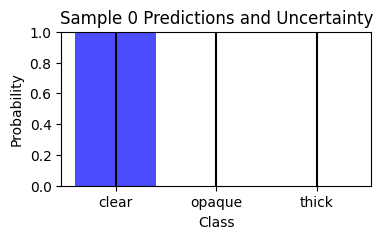

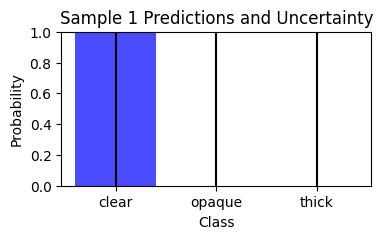

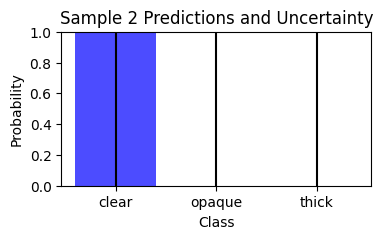

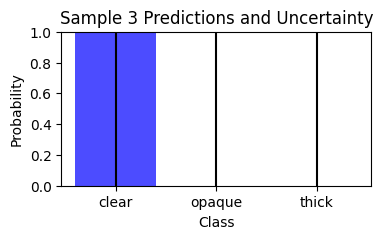

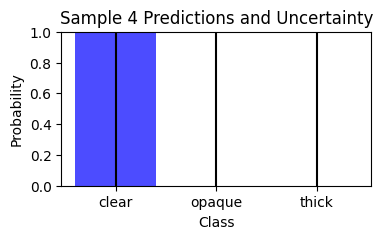

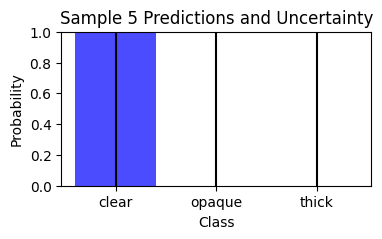

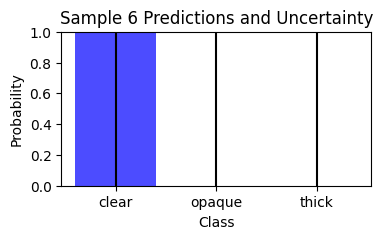

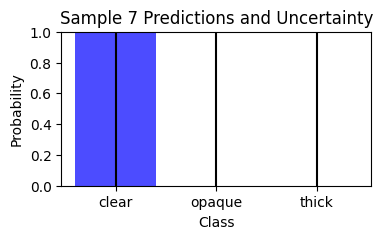

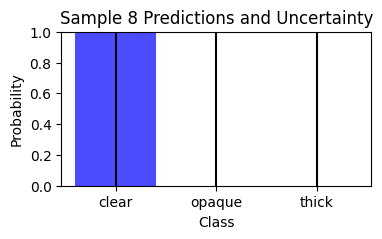

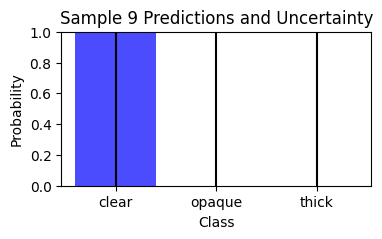

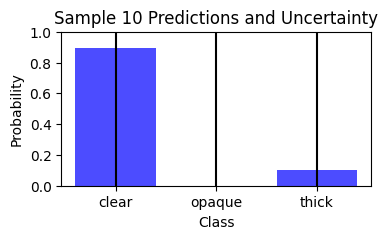

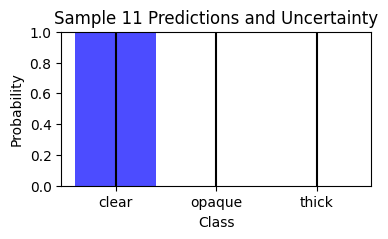

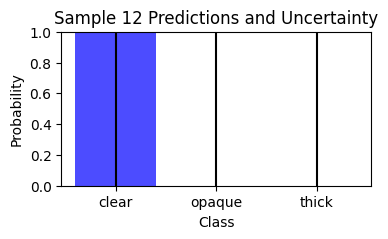

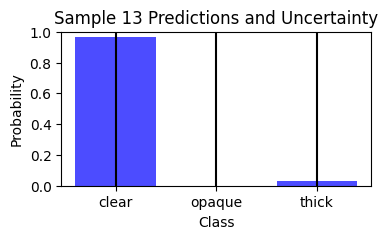

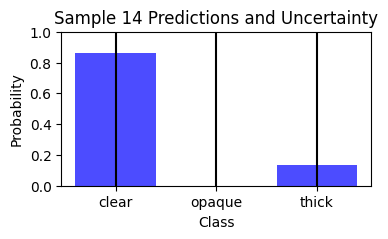

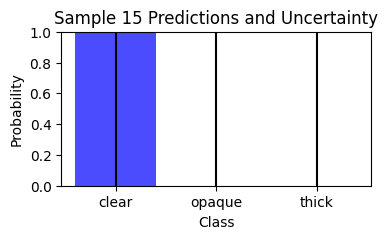

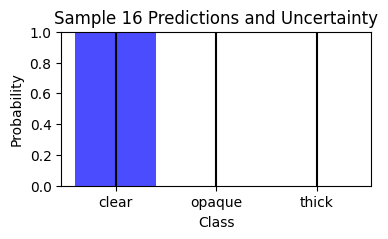

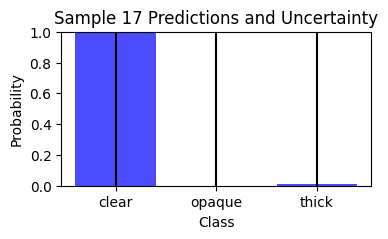

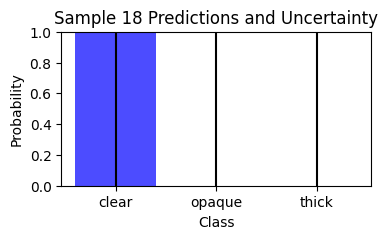

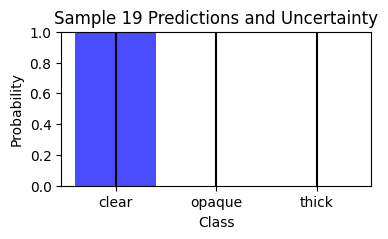

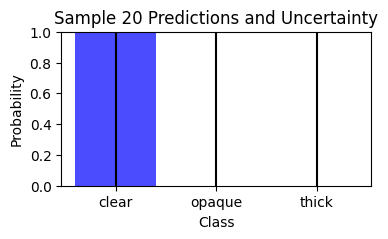

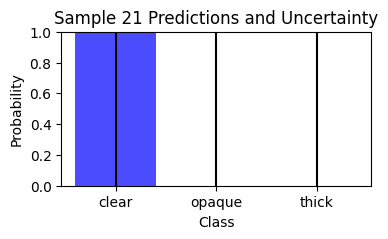

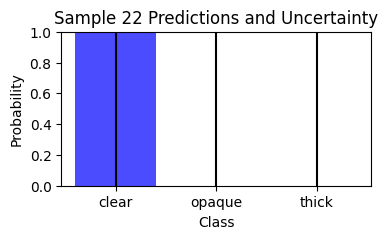

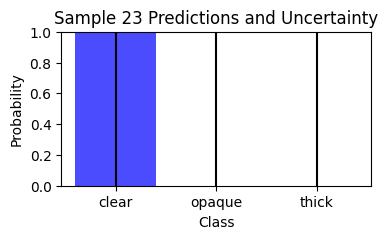

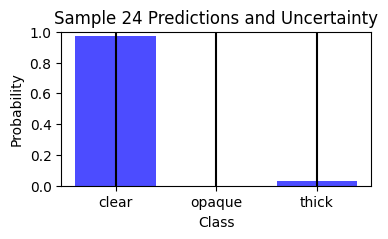

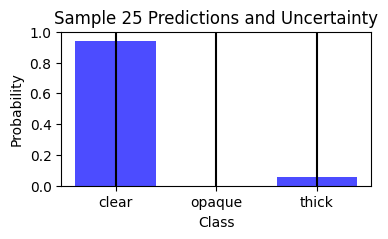

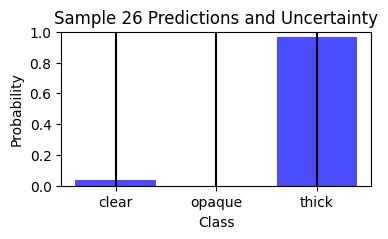

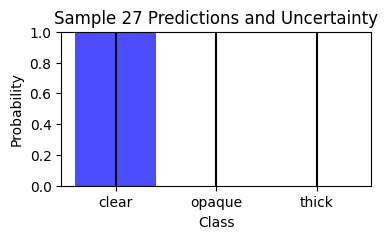

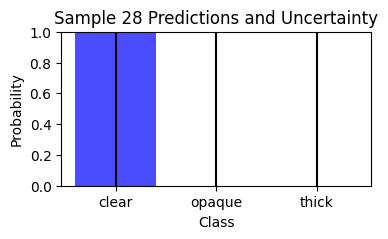

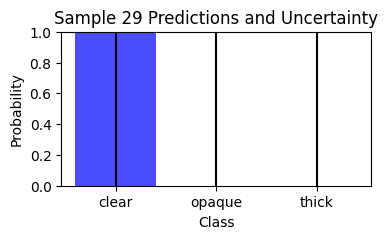

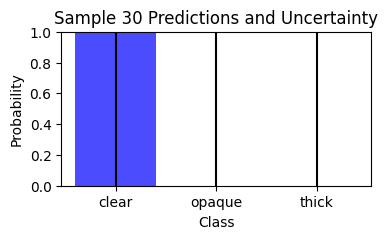

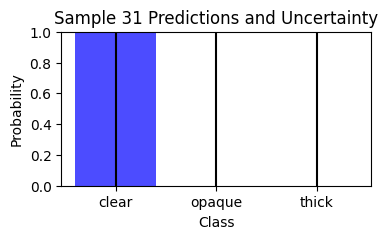

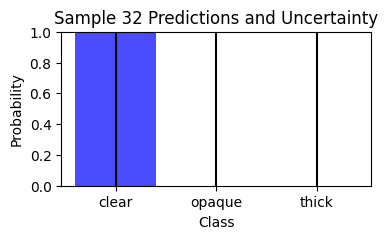

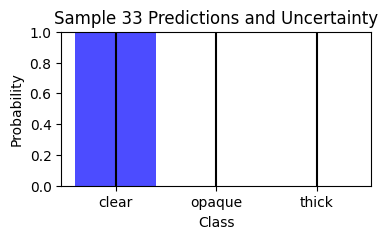

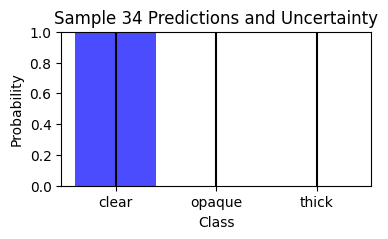

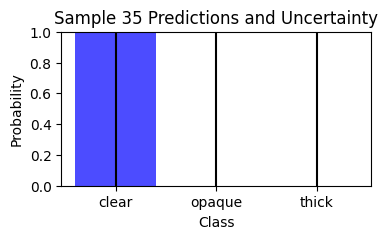

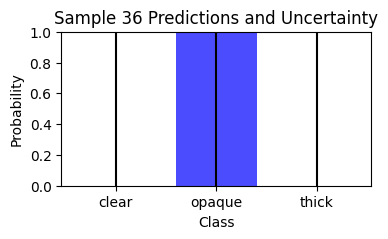

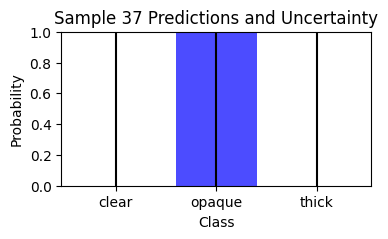

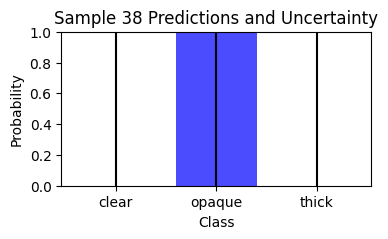

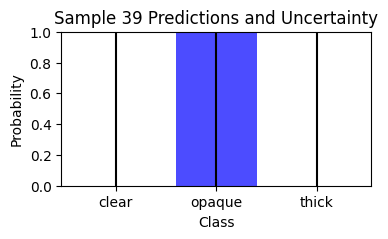

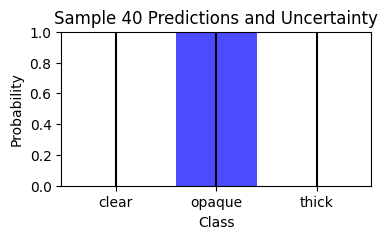

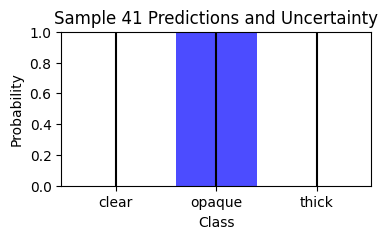

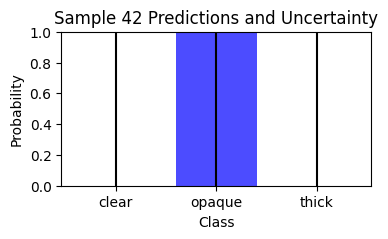

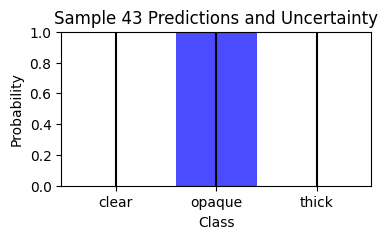

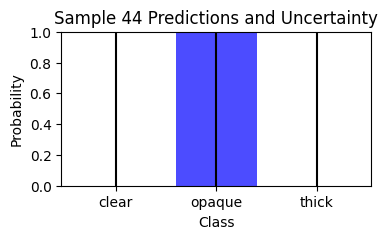

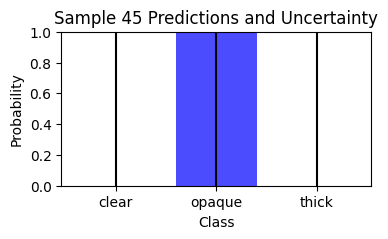

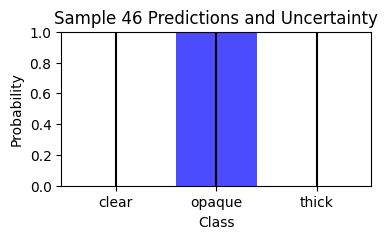

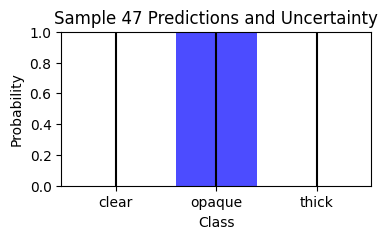

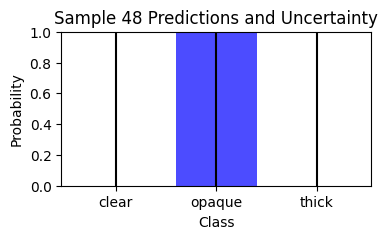

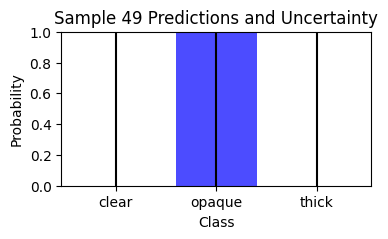

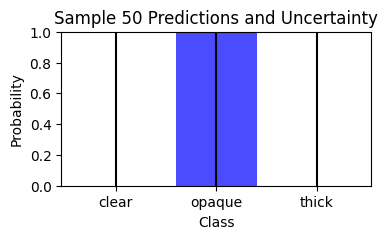

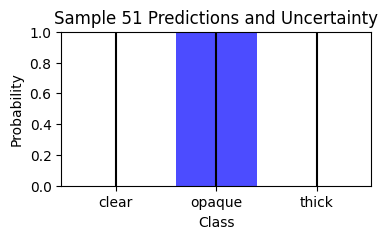

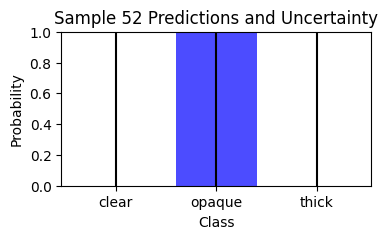

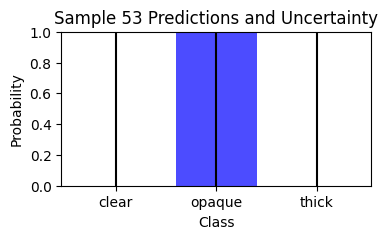

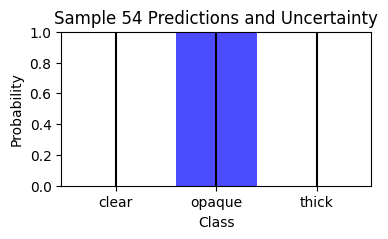

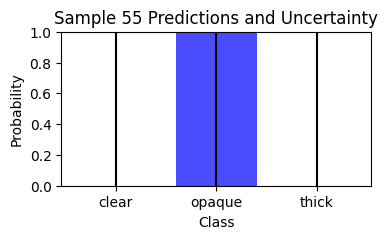

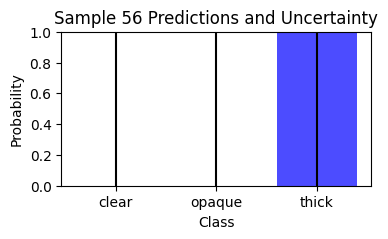

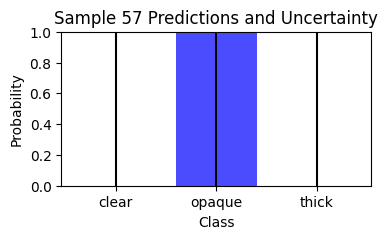

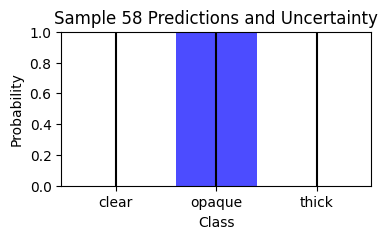

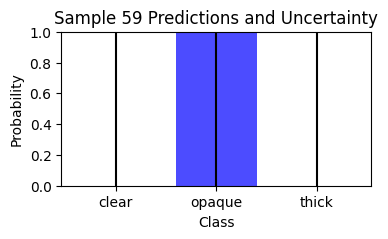

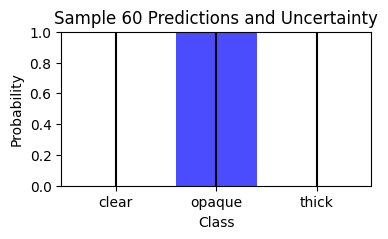

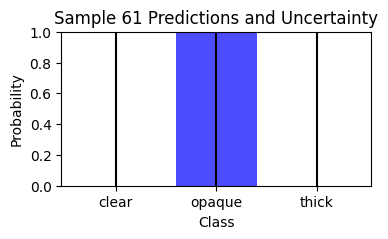

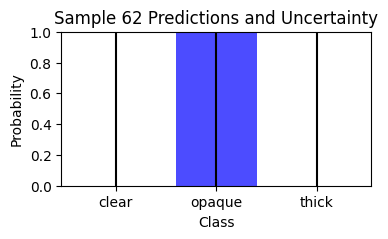

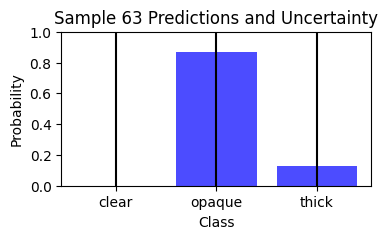

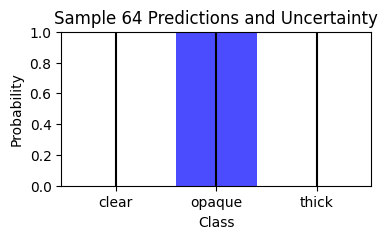

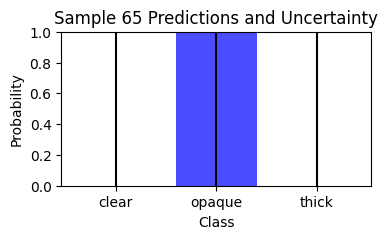

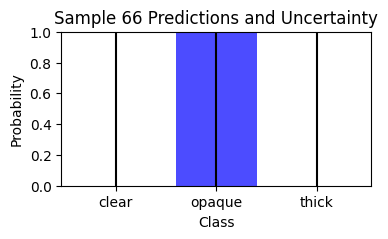

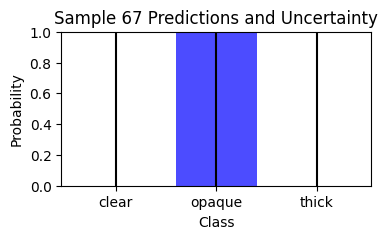

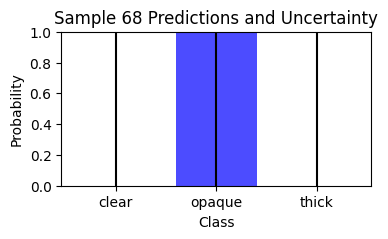

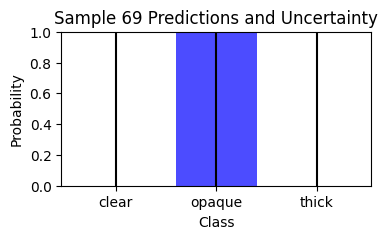

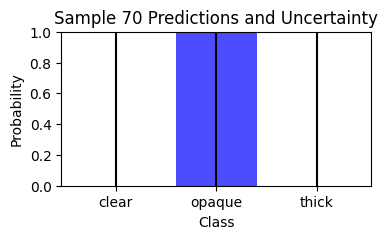

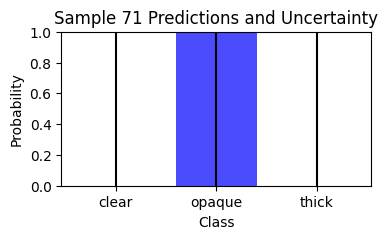

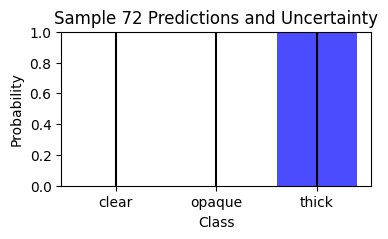

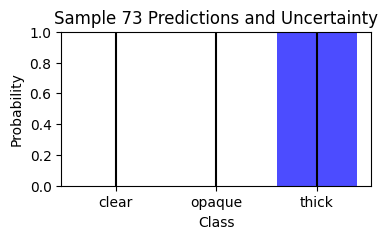

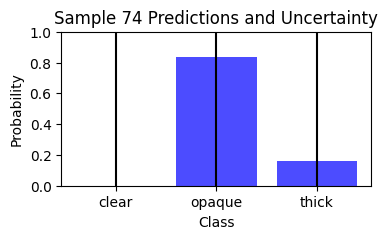

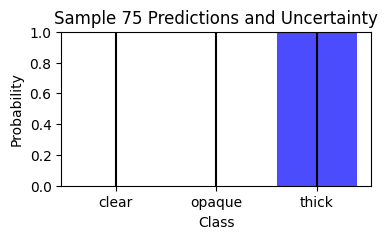

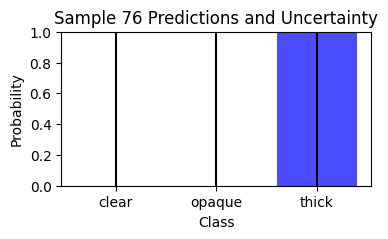

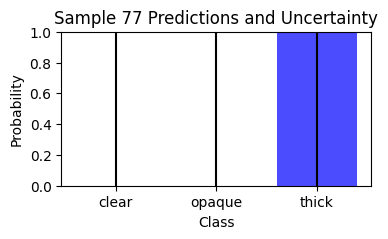

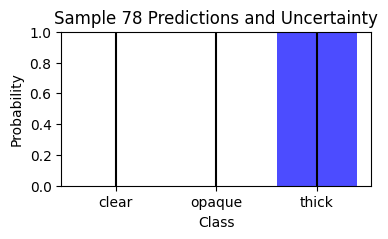

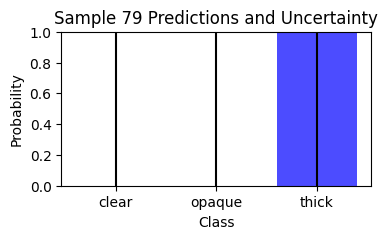

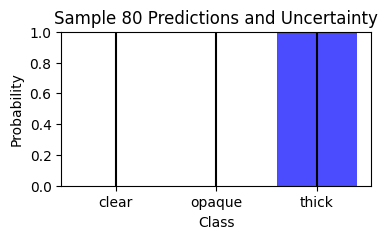

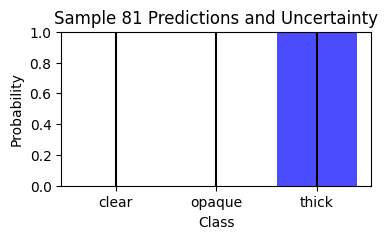

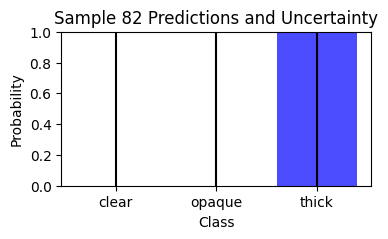

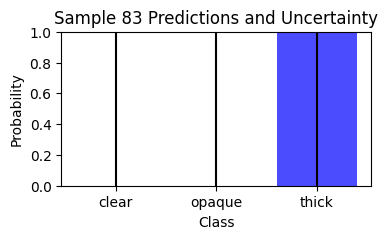

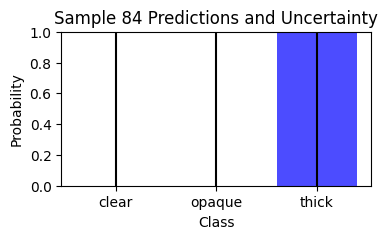

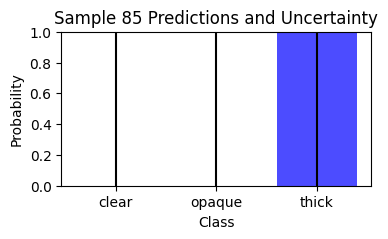

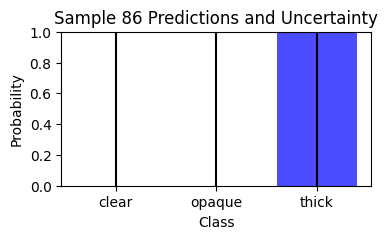

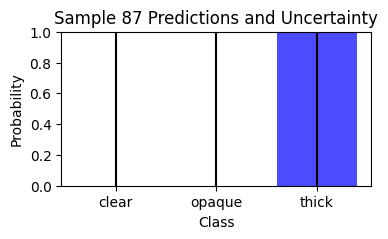

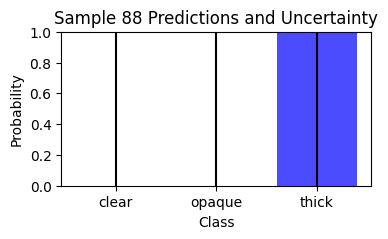

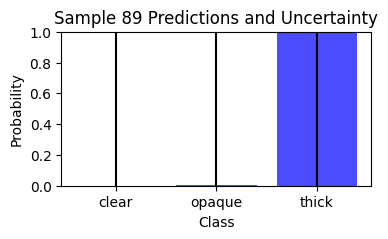

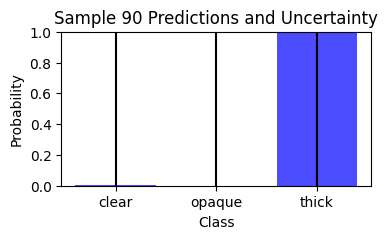

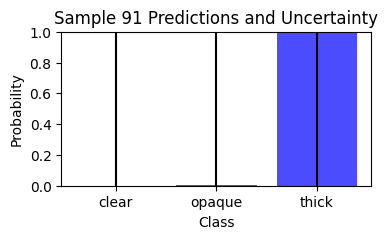

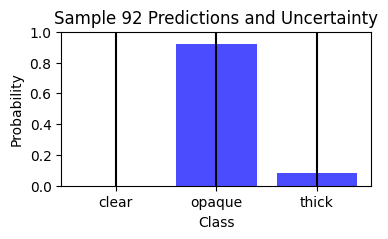

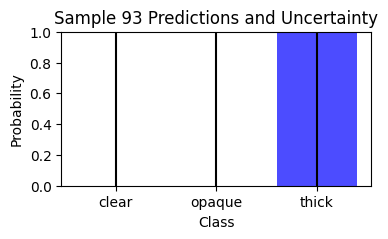

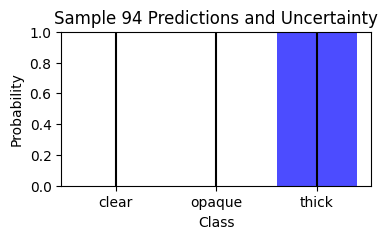

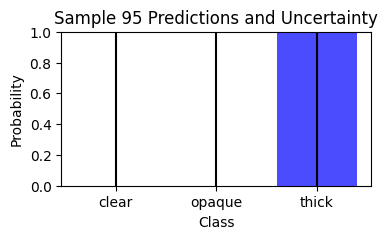

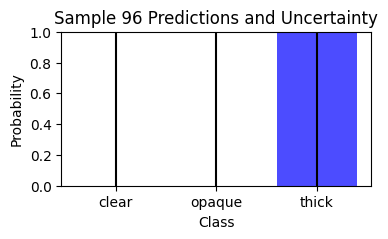

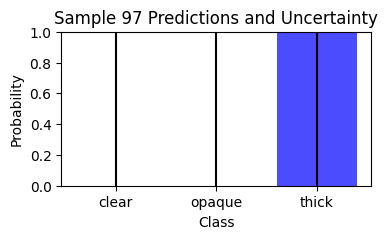

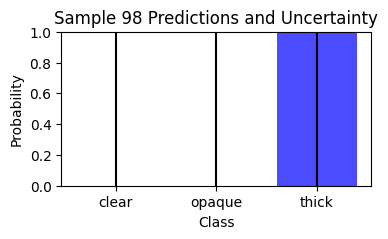

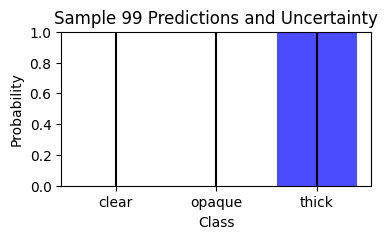

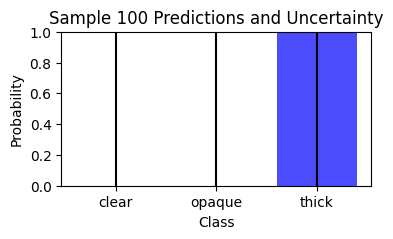

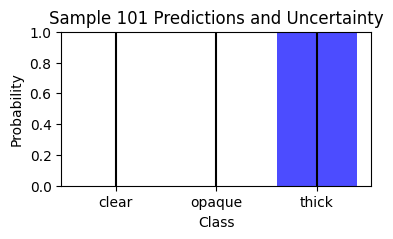

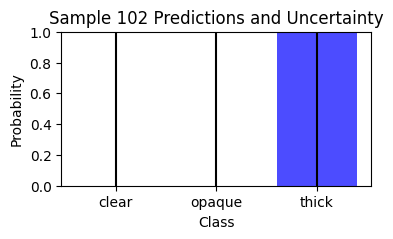

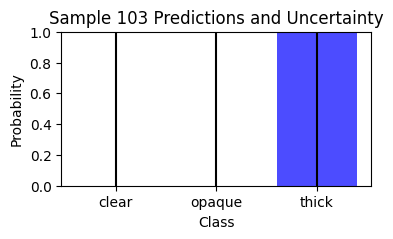

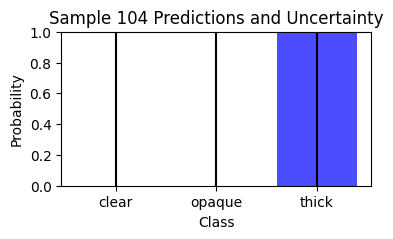

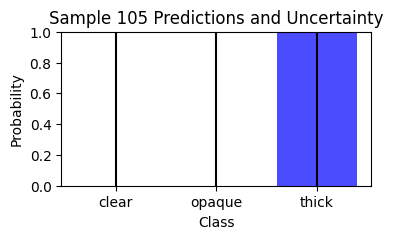

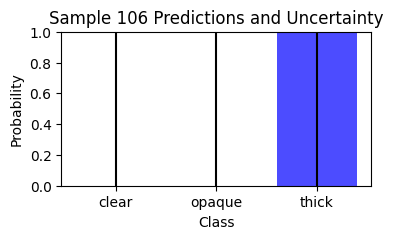

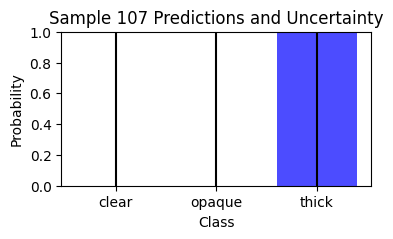

In [ ]:
for i in range(len(x_test)):
    plot_uncertainty(mean_predictions[i], prediction_variance[i], i)

###4. Visualization of class probabilities

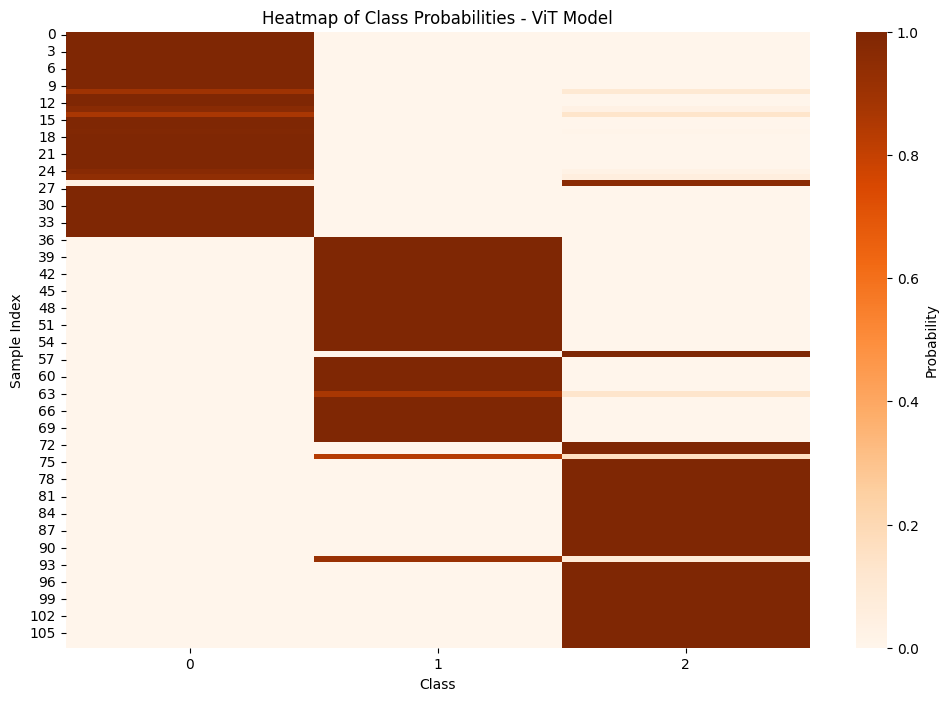

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(probabilities, cmap='Oranges', cbar_kws={'label': 'Probability'}, annot=False, fmt=".2f")
plt.xlabel('Class')
plt.ylabel('Sample Index')
plt.title('Heatmap of Class Probabilities - ViT Model')
plt.show()

###5. Variance analysis

In [ ]:
# Differences in variances for each sample
variance_differences = []
for i, variances in enumerate(prediction_variance):
    diff_0_1 = variances[1] - variances[0]  # Difference between Class 0 and Class 1
    diff_1_2 = variances[2] - variances[1]  # Difference between Class 1 and Class 2
    diff_0_2 = variances[2] - variances[0]  # Difference between Class 0 and Class 2

    variance_differences.append((diff_0_1, diff_1_2, diff_0_2))

    print(f"Sample {i}:")
    print(f"Variance differences - Class 0 to 1: {diff_0_1}, Class 1 to 2: {diff_1_2}, Class 0 to 2: {diff_0_2}")

Sample 0:
Variance differences - Class 0 to 1: 88.74171903, Class 1 to 2: -108.02575546, Class 0 to 2: -19.28403643
Sample 1:
Variance differences - Class 0 to 1: 64.68933761, Class 1 to 2: -95.133308, Class 0 to 2: -30.443970389999997
Sample 2:
Variance differences - Class 0 to 1: 64.59880677000001, Class 1 to 2: -84.89451744, Class 0 to 2: -20.29571067
Sample 3:
Variance differences - Class 0 to 1: 51.64525721, Class 1 to 2: -95.16602092, Class 0 to 2: -43.52076371
Sample 4:
Variance differences - Class 0 to 1: 77.63976013999999, Class 1 to 2: -132.5683211, Class 0 to 2: -54.928560960000006
Sample 5:
Variance differences - Class 0 to 1: 66.08224854999999, Class 1 to 2: -96.59848147999999, Class 0 to 2: -30.51623293
Sample 6:
Variance differences - Class 0 to 1: 113.19456828999999, Class 1 to 2: -156.95168703, Class 0 to 2: -43.75711874000001
Sample 7:
Variance differences - Class 0 to 1: 63.27957029, Class 1 to 2: -82.82484721, Class 0 to 2: -19.54527692
Sample 8:
Variance difference

###Section 2

###1. Calculation of Expected Calibration Error (ECE)

In [ ]:
def calculate_ece(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    ece = 0.0

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(y_true[in_bin])
            avg_confidence_in_bin = np.mean(y_prob[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

prediction_mean, _ = predict_with_uncertainty(vit_model, x_test, n_iter=100)
prediction_probabilities = softmax(prediction_mean)

for class_index in range(NUM_CLASSES):
    positive_class_prob = prediction_probabilities[:, class_index]
    binary_y_true = (y_test == class_index).astype(int)
    ece = calculate_ece(binary_y_true, positive_class_prob)
    print(f"Expected Calibration Error (ECE) for Class {class_index}: {ece:.4f}")

Expected Calibration Error (ECE) for Class 0: 0.0132
Expected Calibration Error (ECE) for Class 1: 0.0251
Expected Calibration Error (ECE) for Class 2: 0.0359


###2. Plotting of calibration curves

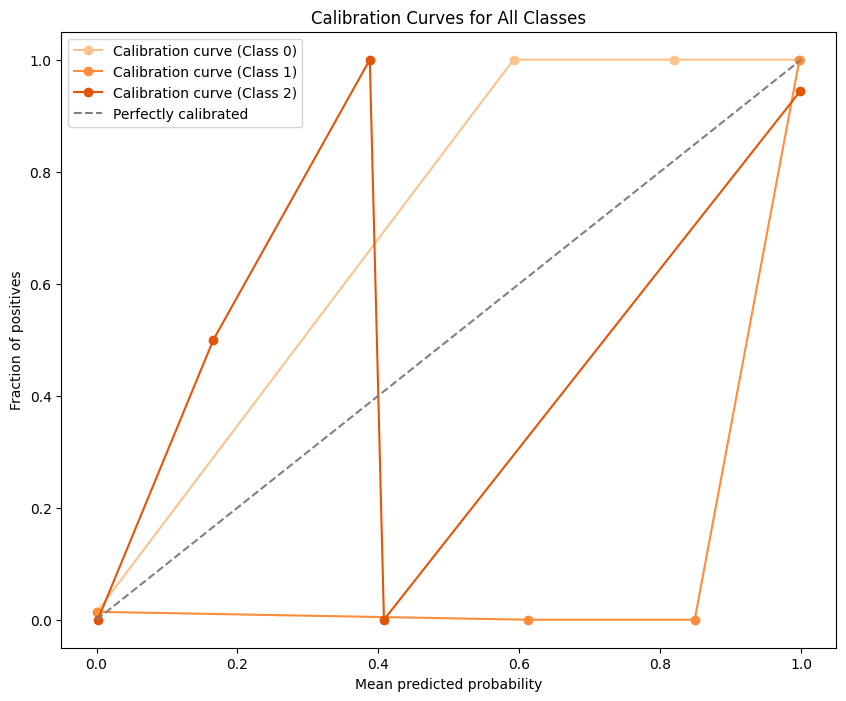

In [ ]:
def plot_calibration_curve(y_true, y_prob, class_index, color, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f'Calibration curve (Class {class_index})', color=color)
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

prediction_mean, _ = predict_with_uncertainty(vit_model, x_test, n_iter=100)
prediction_probabilities = softmax(prediction_mean)
base_color = cm.Oranges
shades = [base_color(i) for i in np.linspace(0.3, 0.7, NUM_CLASSES)]

plt.figure(figsize=(10, 8))
for class_index in range(NUM_CLASSES):
    positive_class_prob = prediction_probabilities[:, class_index]
    binary_y_true = (y_test == class_index).astype(int)
    plot_calibration_curve(binary_y_true, positive_class_prob, class_index=class_index, color=shades[class_index])
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves for All Classes')
plt.legend()
plt.show()

###Section 3. Calculation of predictive entropy

In [ ]:
def calculate_predictive_entropy(predictive_mean):
    probabilities = np.clip(predictive_mean, 1e-10, 1.0)
    return -np.sum(probabilities * np.log(probabilities), axis=-1)

In [ ]:
prediction_mean, prediction_variance = predict_with_uncertainty(vit_model, x_test, n_iter=100)
predictive_entropy = calculate_predictive_entropy(prediction_mean)

for i in range(len(x_test)):
    print(f"Sample {i}:")
    print(f"  Predicted Class: {class_labels[np.argmax(prediction_mean[i])]}")
    print(f"  Predictive Entropy: {predictive_entropy[i]:.4f}")
    print()

Sample 0:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 1:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 2:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 3:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 4:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 5:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 6:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 7:
  Predicted Class: clear
  Predictive Entropy: 0.1637

Sample 8:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 9:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 10:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 11:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 12:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 13:
  Predicted Class: clear
  Predictive Entropy: 0.3670

Sample 14:
  Predicted Class: clear
  Predictive Entropy: 0.0000

Sample 15:
  Predict

###Section 4

###Calibration of ViT model

In [ ]:
# Remove the data augmentation layer for inference
model_without_augmentation = Model(inputs=vit_model.input, outputs=vit_model.layers[1].output)
predicted_probabilities = model_without_augmentation.predict(x_test, batch_size=32, verbose=1)
if y_test.ndim > 1 and y_test.shape[1] > 1:
    true_labels = np.argmax(y_test, axis=1)
else:
    true_labels = y_test

print("Predicted Probabilities:")
print(predicted_probabilities[:107])
print("True Class Labels:")
print(true_labels[:107])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted Probabilities:
[[[[-1.410691   -1.410691   -1.4106911 ]
   [-1.3551909  -1.3551909  -1.355191  ]
   [-1.4957911  -1.4957911  -1.4957912 ]
   ...
   [-0.1535071  -0.1535071  -0.15350711]
   [-0.11527857 -0.11527857 -0.11527858]
   [-0.15721358 -0.15721358 -0.1572136 ]]

  [[-0.3249456  -0.3249456  -0.32494563]
   [ 0.40929934  0.40929934  0.40929937]
   [ 0.23293269  0.23293269  0.2329327 ]
   ...
   [-0.14323369 -0.14323369 -0.1432337 ]
   [-0.08732189 -0.08732189 -0.0873219 ]
   [-0.18639967 -0.18639967 -0.18639968]]

  [[-0.12473451 -0.12473451 -0.12473452]
   [ 0.426155    0.426155    0.42615503]
   [ 0.36448827  0.36448827  0.3644883 ]
   ...
   [-0.11856391 -0.11856391 -0.11856391]
   [-0.00345951 -0.00345951 -0.00345951]
   [-0.18845591 -0.18845591 -0.18845592]]

  ...

  [[ 0.38298854  0.38298854  0.38298857]
   [ 0.26787636  0.26787636  0.26787636]
   [ 0.16920911  0.16920911  0.16920911]
   ...
   [ 0.17948814  0.17948814  0.1794

In [ ]:
predicted_probabilities = softmax(prediction_mean, axis=-1)
true_labels = y_test.astype(int)

print("Predicted Probabilities (after softmax):")
print(predicted_probabilities[:108])
print("True Class Labels:")
print(true_labels[:108])

Predicted Probabilities (after softmax):
[[9.99995191e-01 7.45791109e-14 4.80937071e-06]
 [1.00000000e+00 9.57982982e-26 2.62189648e-12]
 [9.99999997e-01 2.80374854e-20 2.77151583e-09]
 [1.00000000e+00 1.36701633e-21 9.96591177e-11]
 [1.00000000e+00 9.85398620e-25 1.98976809e-12]
 [1.00000000e+00 3.05014350e-28 2.30978755e-13]
 [9.99999953e-01 1.07675265e-17 4.65434792e-08]
 [9.99925740e-01 2.16635596e-11 7.42599863e-05]
 [1.00000000e+00 2.06339876e-19 3.72053804e-10]
 [9.99950996e-01 4.03496468e-11 4.90043163e-05]
 [8.99119574e-01 8.09882320e-06 1.00872328e-01]
 [1.00000000e+00 1.38153833e-23 1.75368316e-10]
 [1.00000000e+00 4.54353174e-22 2.18260016e-10]
 [9.85411735e-01 3.37133104e-06 1.45848939e-02]
 [8.69174439e-01 5.82019156e-06 1.30819740e-01]
 [9.99999998e-01 6.40977042e-19 1.92968300e-09]
 [9.99999578e-01 1.42534130e-14 4.22269461e-07]
 [9.93810407e-01 1.96406396e-08 6.18957328e-03]
 [9.99960348e-01 1.71981012e-10 3.96521410e-05]
 [1.00000000e+00 4.32184998e-26 2.06977013e-13]

In [ ]:
prob_train, prob_val, labels_train, labels_val = train_test_split(predicted_probabilities, true_labels, test_size=0.2, random_state=42)
base_model = LogisticRegression(multi_class='ovr', max_iter=1000)
base_model.fit(prob_train, labels_train)

# Calibrate the model using Platt Scaling
calibrated_model_platt = CalibratedClassifierCV(estimator=base_model, method='sigmoid', cv='prefit')
calibrated_model_platt.fit(prob_val, labels_val)
# Calibrate the model using Isotonic Regression
calibrated_model_isotonic = CalibratedClassifierCV(estimator=base_model, method='isotonic', cv='prefit')
calibrated_model_isotonic.fit(prob_val, labels_val)

calibrated_probabilities_platt = calibrated_model_platt.predict_proba(prob_val)
calibrated_probabilities_isotonic = calibrated_model_isotonic.predict_proba(prob_val)

log_loss_platt = log_loss(labels_val, calibrated_probabilities_platt)
log_loss_isotonic = log_loss(labels_val, calibrated_probabilities_isotonic)
print(f"Log Loss (Platt Scaling): {log_loss_platt:.4f}")
print(f"Log Loss (Isotonic Regression): {log_loss_isotonic:.4f}")

Log Loss (Platt Scaling): 0.2624
Log Loss (Isotonic Regression): 0.0375


In [ ]:
print(calibrated_probabilities_platt[:108])

[[0.07022304 0.11007187 0.8197051 ]
 [0.81669005 0.11083796 0.07247199]
 [0.84511279 0.10837875 0.04650846]
 [0.07022549 0.11007258 0.81970193]
 [0.04514259 0.88031311 0.0745443 ]
 [0.04514259 0.88031311 0.0745443 ]
 [0.84511279 0.10837875 0.04650846]
 [0.04514259 0.88031311 0.0745443 ]
 [0.07022304 0.11007187 0.8197051 ]
 [0.84511279 0.10837875 0.04650846]
 [0.07022304 0.11007187 0.81970509]
 [0.07022309 0.11007249 0.81970442]
 [0.84511171 0.10837884 0.04650945]
 [0.07022304 0.11007187 0.8197051 ]
 [0.84510391 0.1083795  0.04651658]
 [0.04514259 0.88031311 0.0745443 ]
 [0.07021778 0.11027994 0.81950228]
 [0.07022335 0.11007262 0.81970403]
 [0.07022293 0.11007598 0.81970109]
 [0.04514259 0.88031311 0.0745443 ]
 [0.84511279 0.10837875 0.04650846]
 [0.04514259 0.88031311 0.0745443 ]]


In [ ]:
print(predicted_probabilities)

[[9.99995191e-01 7.45791109e-14 4.80937071e-06]
 [1.00000000e+00 9.57982982e-26 2.62189648e-12]
 [9.99999997e-01 2.80374854e-20 2.77151583e-09]
 [1.00000000e+00 1.36701633e-21 9.96591177e-11]
 [1.00000000e+00 9.85398620e-25 1.98976809e-12]
 [1.00000000e+00 3.05014350e-28 2.30978755e-13]
 [9.99999953e-01 1.07675265e-17 4.65434792e-08]
 [9.99925740e-01 2.16635596e-11 7.42599863e-05]
 [1.00000000e+00 2.06339876e-19 3.72053804e-10]
 [9.99950996e-01 4.03496468e-11 4.90043163e-05]
 [8.99119574e-01 8.09882320e-06 1.00872328e-01]
 [1.00000000e+00 1.38153833e-23 1.75368316e-10]
 [1.00000000e+00 4.54353174e-22 2.18260016e-10]
 [9.85411735e-01 3.37133104e-06 1.45848939e-02]
 [8.69174439e-01 5.82019156e-06 1.30819740e-01]
 [9.99999998e-01 6.40977042e-19 1.92968300e-09]
 [9.99999578e-01 1.42534130e-14 4.22269461e-07]
 [9.93810407e-01 1.96406396e-08 6.18957328e-03]
 [9.99960348e-01 1.71981012e-10 3.96521410e-05]
 [1.00000000e+00 4.32184998e-26 2.06977013e-13]
 [9.99993353e-01 1.29417061e-13 6.646809

In [ ]:
print(true_labels[:108])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


Calibration curves after Calibration

Log Loss (Platt Scaling): 0.2659
Log Loss (Isotonic Regression): 0.0375


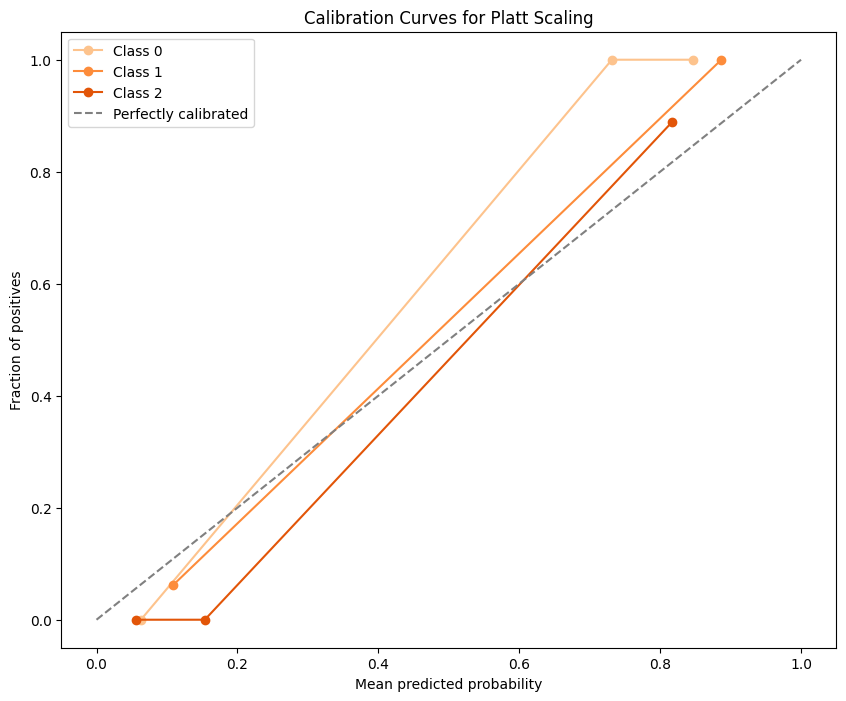

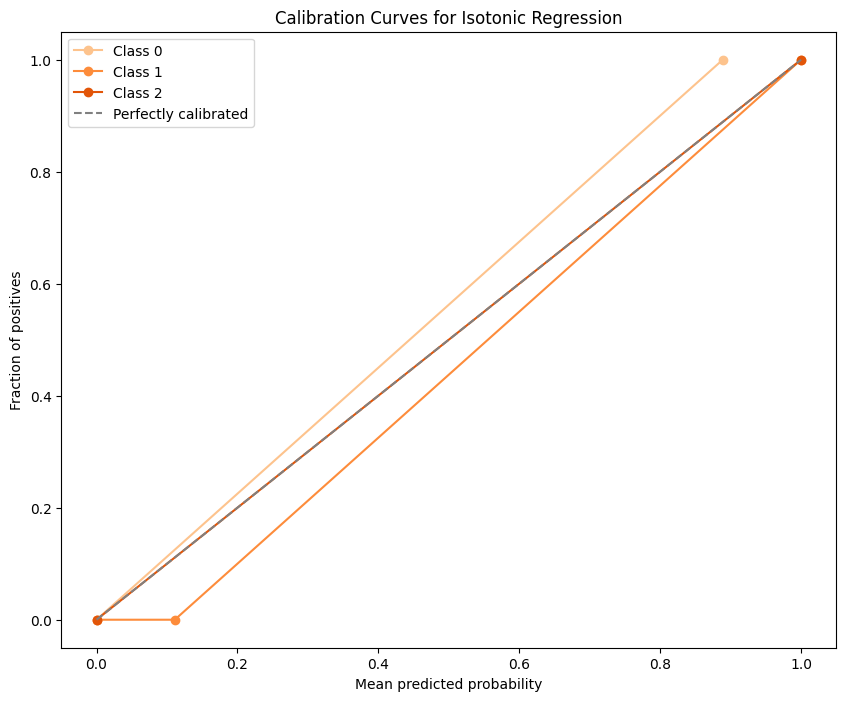

In [ ]:
def plot_calibration_curve(y_true, y_prob, class_index, color, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_index}', color=color)
NUM_CLASSES = calibrated_probabilities_platt.shape[1]
base_color = cm.Oranges
shades = [base_color(i) for i in np.linspace(0.3, 0.7, NUM_CLASSES)]

# Plot calibration curve for each class using Platt scaling
plt.figure(figsize=(10, 8))
for class_index in range(NUM_CLASSES):
    calibrated_probabilities_platt_class = calibrated_probabilities_platt[:, class_index]
    binary_y_true = (labels_val == class_index).astype(int)
    plot_calibration_curve(binary_y_true, calibrated_probabilities_platt_class, class_index=class_index, color=shades[class_index])
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves for Platt Scaling')
plt.legend()
plt.show()

# Plot calibration curve for each class using Isotonic regression
plt.figure(figsize=(10, 8))
for class_index in range(NUM_CLASSES):
    calibrated_probabilities_isotonic_class = calibrated_probabilities_isotonic[:, class_index]
    binary_y_true = (labels_val == class_index).astype(int)
    plot_calibration_curve(binary_y_true, calibrated_probabilities_isotonic_class, class_index=class_index, color=shades[class_index])
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves for Isotonic Regression')
plt.legend()
plt.show()

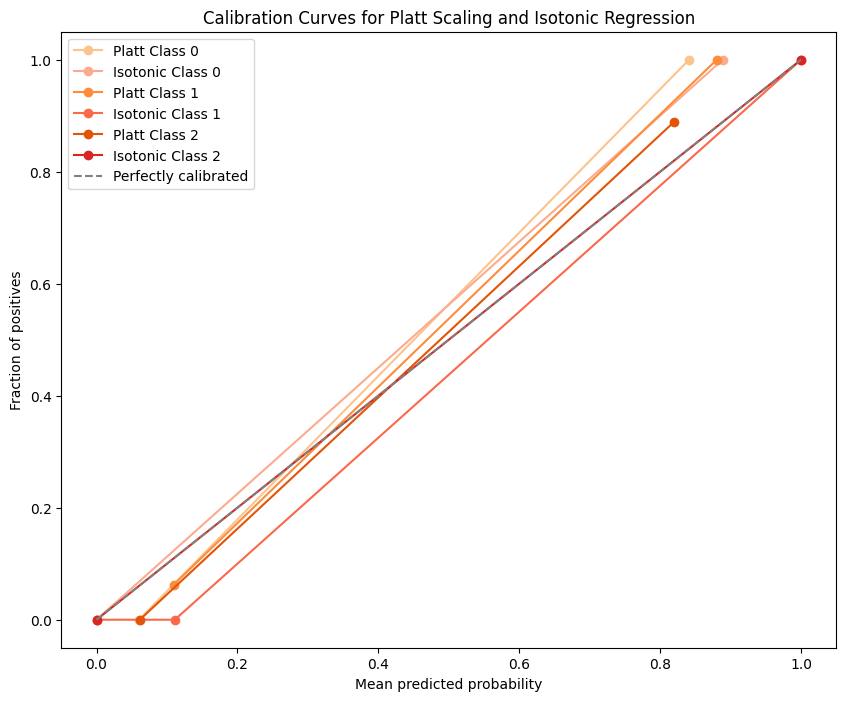

In [ ]:
def plot_calibration_curve(y_true, y_prob, class_index, color, label_prefix, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f'{label_prefix} Class {class_index}', color=color)

NUM_CLASSES = calibrated_probabilities_platt.shape[1]

platt_base_color = cm.Oranges
isotonic_base_color = cm.Reds
platt_shades = [platt_base_color(i) for i in np.linspace(0.3, 0.7, NUM_CLASSES)]
isotonic_shades = [isotonic_base_color(i) for i in np.linspace(0.3, 0.7, NUM_CLASSES)]

plt.figure(figsize=(10, 8))
for class_index in range(NUM_CLASSES):
    # Platt scaling
    calibrated_probabilities_platt_class = calibrated_probabilities_platt[:, class_index]
    binary_y_true = (labels_val == class_index).astype(int)
    plot_calibration_curve(binary_y_true, calibrated_probabilities_platt_class, class_index=class_index, color=platt_shades[class_index], label_prefix='Platt')
    # Isotonic regression
    calibrated_probabilities_isotonic_class = calibrated_probabilities_isotonic[:, class_index]
    plot_calibration_curve(binary_y_true, calibrated_probabilities_isotonic_class, class_index=class_index, color=isotonic_shades[class_index], label_prefix='Isotonic')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves for Platt Scaling and Isotonic Regression')
plt.legend()
plt.show()

###Section 5

###1. Calculation of Total, Aleatoric and Epistemic Uncertainty

In [ ]:
def predict_with_uncertainty(model, x, n_iter=100):
    predictions = np.array([model(x, training=True) for _ in range(n_iter)])
    prediction_mean = np.mean(predictions, axis=0)
    prediction_variance = np.var(predictions, axis=0)
    return prediction_mean, predictions

predictions, posterior_samples = predict_with_uncertainty(vit_model, x_test)

epsilon = 1e-10
posterior_samples = np.clip(posterior_samples, epsilon, 1.0)

total_uncertainties = []
aleatoric_uncertainties = []
epistemic_uncertainties = []
for i in range(x_test.shape[0]):
    average_prediction = np.mean(posterior_samples[:, i, :], axis=0)
    total_uncertainty = entropy(average_prediction, axis=-1)
    aleatoric_uncertainty = np.mean([entropy(sample[i, :], axis=-1) for sample in posterior_samples], axis=0)
    epistemic_uncertainty = total_uncertainty - aleatoric_uncertainty

    total_uncertainties.append(total_uncertainty)
    aleatoric_uncertainties.append(aleatoric_uncertainty)
    epistemic_uncertainties.append(epistemic_uncertainty)

for idx, (tu, au, eu) in enumerate(zip(total_uncertainties, aleatoric_uncertainties, epistemic_uncertainties)):
    print(f"Image {idx + 1}:")
    print(f"  Total Uncertainty (TU): {tu}")
    print(f"  Aleatoric Uncertainty (AU): {au}")
    print(f"  Epistemic Uncertainty (EU): {eu}")

Image 1:
  Total Uncertainty (TU): 0.540901780128479
  Aleatoric Uncertainty (AU): 0.23661738634109497
  Epistemic Uncertainty (EU): 0.30428439378738403
Image 2:
  Total Uncertainty (TU): 0.48416823148727417
  Aleatoric Uncertainty (AU): 0.17127542197704315
  Epistemic Uncertainty (EU): 0.3128927946090698
Image 3:
  Total Uncertainty (TU): 0.3845408856868744
  Aleatoric Uncertainty (AU): 0.11105731129646301
  Epistemic Uncertainty (EU): 0.2734835743904114
Image 4:
  Total Uncertainty (TU): 0.38483312726020813
  Aleatoric Uncertainty (AU): 0.12162446230649948
  Epistemic Uncertainty (EU): 0.26320865750312805
Image 5:
  Total Uncertainty (TU): 0.37248075008392334
  Aleatoric Uncertainty (AU): 0.09704061597585678
  Epistemic Uncertainty (EU): 0.27544012665748596
Image 6:
  Total Uncertainty (TU): 0.3444707989692688
  Aleatoric Uncertainty (AU): 0.09971761703491211
  Epistemic Uncertainty (EU): 0.2447531819343567
Image 7:
  Total Uncertainty (TU): 0.5325232744216919
  Aleatoric Uncertainty

###Comparison of all three models

In [ ]:
CNN_aleatoric = [0.5839155316352844,
0.6446260213851929,
0.6429187655448914,
0.6580913662910461,
0.52989661693573,
0.5310292840003967,
0.6584897637367249,
0.6792842149734497,
0.5867881774902344,
0.6792842149734497,
0.6446268558502197,
0.5165649652481079,
0.6229555606842041,
0.6556881070137024,
0.6296749114990234,
0.6223167777061462,
0.5827040672302246,
0.6370179653167725,
0.6170662045478821,
0.6369549036026001,
0.4946955740451813,
0.6233930587768555,
0.6468851566314697,
0.6572854518890381,
0.6862156391143799,
0.6501860618591309,
0.6787294149398804,
0.6512725949287415,
0.6707350015640259,
0.5961065292358398,
0.5255164504051208,
0.5683587193489075,
0.6720939874649048,
0.5947612524032593,
0.6861782670021057,
0.6409847736358643,
0.054861459881067276,
0.6855583190917969,
0.5821088552474976,
0.3753763437271118,
0.36057814955711365,
0.34999579191207886,
0.5492547750473022,
0.6099965572357178,
0.4320608377456665,
0.4095863997936249,
0.537844717502594,
0.630240797996521,
0.5972095727920532,
0.19375820457935333,
0.39811965823173523,
0.5520222187042236,
0.6551210880279541,
0.6041677594184875,
0.2095283716917038,
0.609447717666626,
0.696841299533844,
0.4810516834259033,
0.6494634747505188,
0.6931353211402893,
0.6251416206359863,
0.6650888323783875,
0.47566473484039307,
0.671680212020874,
0.5122803449630737,
0.6300493478775024,
0.566881000995636,
0.5420069098472595,
0.5470133423805237,
0.648549497127533,
0.5821915864944458,
0.6488432884216309,
0.8082375526428223,
0.6363538503646851,
0.739013671875,
0.7363114356994629,
0.6587414741516113,
0.6970489621162415,
0.7217788100242615,
0.7224434018135071,
0.7517969608306885,
0.6690040826797485,
0.5863435864448547,
0.5980117917060852,
0.5912759304046631,
0.7516474723815918,
0.6900849342346191,
0.7410642504692078,
0.6323795914649963,
0.7177534699440002,
0.6907169222831726,
0.6947289109230042,
0.8004802465438843,
0.8317065238952637,
0.6135333776473999,
0.7763782739639282,
0.6406354308128357,
0.7489461302757263,
0.7071261405944824,
0.7524756789207458,
0.7132905721664429,
0.7881614565849304,
0.7635512351989746,
0.6676591634750366,
0.8489925861358643,
0.7486105561256409,
0.7171447277069092,
0.7012553215026855
]

In [ ]:
ViT_aleatoric = [0.23661738634109497,
0.17127542197704315,
0.11105731129646301,
0.12162446230649948,
0.09704061597585678,
0.09971761703491211,
0.21741439402103424,
0.3349888324737549,
0.08133833110332489,
0.22344446182250977,
0.34587618708610535,
0.0964946448802948,
0.11005214601755142,
0.4092908501625061,
0.4760327637195587,
0.09741783142089844,
0.15353243052959442,
0.4688779413700104,
0.24239683151245117,
0.06515374034643173,
0.3034256398677826,
0.32613593339920044,
0.1627173274755478,
0.16527965664863586,
0.3919733464717865,
0.5119481682777405,
0.3906589448451996,
0.21751777827739716,
0.13010795414447784,
0.061390530318021774,
0.09694898873567581,
0.17414100468158722,
0.1059836745262146,
0.16540661454200745,
0.1279054433107376,
0.22572359442710876,
0.5025147199630737,
0.5516712665557861,
0.3420226275920868,
0.2710823714733124,
0.28083595633506775,
0.3650294244289398,
0.2586723864078522,
0.29560503363609314,
0.24648965895175934,
0.2970398962497711,
0.37634292244911194,
0.424947589635849,
0.35731446743011475,
0.34074991941452026,
0.39191296696662903,
0.3021700382232666,
0.3114466667175293,
0.3595922589302063,
0.3701532781124115,
0.2317824810743332,
0.44012823700904846,
0.49875736236572266,
0.40827569365501404,
0.5400644540786743,
0.2501917779445648,
0.5825371742248535,
0.38048484921455383,
0.5051817893981934,
0.3905026912689209,
0.30202922224998474,
0.27013951539993286,
0.27358296513557434,
0.3122313618659973,
0.44302651286125183,
0.17199844121932983,
0.3288843631744385,
0.2156771868467331,
0.23796427249908447,
0.6047543883323669,
0.22125208377838135,
0.1370115578174591,
0.23263652622699738,
0.33739277720451355,
0.22436514496803284,
0.4802120625972748,
0.2250790148973465,
0.4597513973712921,
0.225801482796669,
0.39971959590911865,
0.16632609069347382,
0.1549891084432602,
0.31991177797317505,
0.32425186038017273,
0.5132849216461182,
0.4860117435455322,
0.5858395099639893,
0.47902899980545044,
0.46833962202072144,
0.20447245240211487,
0.3285861611366272,
0.36921295523643494,
0.40568920969963074,
0.36780673265457153,
0.22977425158023834,
0.29793447256088257,
0.22127878665924072,
0.2302948534488678,
0.1381620466709137,
0.509101927280426,
0.2591876685619354,
0.4180814325809479,
0.17721782624721527
]

In [ ]:
gMLP_aleatoric = [4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
0.013470225036144257,
4.605170023097571e-09,
4.605170023097571e-09,
0.01789957284927368,
4.605170023097571e-09,
4.605170023097571e-09,
0.18929165601730347,
4.605170023097571e-09,
4.605170023097571e-09,
0.017575746402144432,
0.020457088947296143,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
0.01172588486224413,
0.061788879334926605,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
0.03731694445014,
0.11328264325857162,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
0.08733060210943222,
0.04766497761011124,
0.09175153821706772,
0.379789799451828,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
0.0032107322476804256,
4.605170023097571e-09,
4.605170023097571e-09,
0.0055026281625032425,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
0.25237810611724854,
0.0064058988355100155,
4.605170023097571e-09,
0.010511846281588078,
4.605170023097571e-09,
0.018341396003961563,
0.45206645131111145,
0.18809930980205536,
4.605170023097571e-09,
4.605170023097571e-09,
0.0510011687874794,
0.006917936727404594,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
0.1121213361620903,
4.605170023097571e-09,
0.30304038524627686,
0.006931475829333067,
0.07680728286504745,
4.605170023097571e-09,
0.2959337830543518,
4.605170023097571e-09,
0.005839786026626825,
4.605170023097571e-09,
0.0069314767606556416,
4.605170023097571e-09,
0.007212535012513399,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
0.053515415638685226,
0.21930041909217834,
0.29528969526290894,
0.0228714756667614,
0.1724221557378769,
0.3804449737071991,
0.147882878780365,
4.605170023097571e-09,
0.2657909095287323,
0.08626952767372131,
0.0059403846971690655,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09,
0.0068522305227816105,
4.605170023097571e-09,
0.01213532593101263,
4.605170023097571e-09,
4.605170023097571e-09,
4.605170023097571e-09
]

In [ ]:
CNN_epistemic = [0.10460656881332397,
0.047858357429504395,
0.049326956272125244,
0.03464418649673462,
0.1533271074295044,
0.15265411138534546,
0.0343286395072937,
0.013811945915222168,
0.10185414552688599,
0.013811945915222168,
0.04786241054534912,
0.16549795866012573,
0.0686296820640564,
0.03694421052932739,
0.06204444169998169,
0.06912273168563843,
0.10643637180328369,
0.05508643388748169,
0.07419568300247192,
0.05517083406448364,
0.18249455094337463,
0.06823223829269409,
0.0454484224319458,
0.035384416580200195,
0.006918907165527344,
0.042335331439971924,
0.014337897300720215,
0.04130411148071289,
0.0221940279006958,
0.09420526027679443,
0.15731185674667358,
0.11981219053268433,
0.020906388759613037,
0.0949866771697998,
0.00695192813873291,
0.05119478702545166,
0.19472593069076538,
0.007539033889770508,
0.10511302947998047,
0.26841163635253906,
0.26498404145240784,
0.2722688317298889,
0.13416343927383423,
0.07998216152191162,
0.229400634765625,
0.24207833409309387,
0.1440160870552063,
0.06133377552032471,
0.0921010971069336,
0.3130621314048767,
0.2467518150806427,
0.13271969556808472,
0.03754281997680664,
0.08535987138748169,
0.30506443977355957,
0.081229567527771,
0.13461488485336304,
0.20025259256362915,
0.043023884296417236,
1.1742115020751953e-05,
0.06639528274536133,
0.02780252695083618,
0.1967584490776062,
0.02129185199737549,
0.16705989837646484,
0.06136375665664673,
0.12053865194320679,
0.14191001653671265,
0.14884871244430542,
0.043715596199035645,
0.10572665929794312,
0.04357194900512695,
0.2617744207382202,
0.38171064853668213,
0.2114742398262024,
0.2878185510635376,
0.3077985644340515,
0.016325414180755615,
0.14665710926055908,
0.24862581491470337,
0.3089632987976074,
0.31168556213378906,
0.18782436847686768,
0.4019978642463684,
0.24589204788208008,
0.2840229272842407,
0.22713983058929443,
0.22096091508865356,
0.2626568675041199,
0.09549146890640259,
0.009644687175750732,
0.11083537340164185,
0.25599563121795654,
0.20423603057861328,
0.38905632495880127,
0.1631450057029724,
0.360118567943573,
0.30642300844192505,
0.058173179626464844,
0.255890429019928,
0.13365018367767334,
0.26514381170272827,
0.29217004776000977,
0.34142112731933594,
0.22964918613433838,
0.16311043500900269,
0.17144906520843506,
0.03997969627380371
]

In [ ]:
ViT_epistemic = [0.30428439378738403,
0.3128927946090698,
0.2734835743904114,
0.26320865750312805,
0.27544012665748596,
0.2447531819343567,
0.31510889530181885,
0.33517909049987793,
0.21965454518795013,
0.33333563804626465,
0.3900999128818512,
0.2589110732078552,
0.25389325618743896,
0.2671734690666199,
0.23189255595207214,
0.2466234564781189,
0.293246865272522,
0.24527832865715027,
0.32206612825393677,
0.2152480185031891,
0.2984139025211334,
0.2904220223426819,
0.3149148225784302,
0.31337442994117737,
0.338718444108963,
0.17662686109542847,
0.5033429861068726,
0.2957689166069031,
0.2904375195503235,
0.20587562024593353,
0.23693153262138367,
0.3065037727355957,
0.23892134428024292,
0.2998429536819458,
0.2936564087867737,
0.3395260274410248,
0.1729142665863037,
0.13847529888153076,
0.28764453530311584,
0.311649888753891,
0.3145042955875397,
0.27093061804771423,
0.3149378001689911,
0.3097415268421173,
0.3159216046333313,
0.3110363185405731,
0.2601628005504608,
0.23461559414863586,
0.2778201103210449,
0.289106547832489,
0.2529798448085785,
0.2999204397201538,
0.29960906505584717,
0.2778993844985962,
0.26329877972602844,
0.32097357511520386,
0.25829562544822693,
0.17712199687957764,
0.2440907061100006,
0.1422685980796814,
0.3126840889453888,
0.10681033134460449,
0.2621561586856842,
0.2915414571762085,
0.2530398368835449,
0.30358877778053284,
0.3128480315208435,
0.31353768706321716,
0.32809823751449585,
0.22144272923469543,
0.3166670501232147,
0.28226572275161743,
0.4000539779663086,
0.40697890520095825,
0.09558743238449097,
0.35756611824035645,
0.33668169379234314,
0.4579823613166809,
0.4790678322315216,
0.4193101227283478,
0.382924348115921,
0.4564008116722107,
0.4110982120037079,
0.3453183174133301,
0.355707049369812,
0.41267192363739014,
0.2941320538520813,
0.4597427248954773,
0.37640056014060974,
0.24842441082000732,
0.23971939086914062,
0.11911886930465698,
0.525789201259613,
0.478660523891449,
0.3607792556285858,
0.34888535737991333,
0.341437429189682,
0.44203880429267883,
0.47634798288345337,
0.48616641759872437,
0.4974885582923889,
0.3822475075721741,
0.4660106599330902,
0.37598440051078796,
0.37064045667648315,
0.5026232004165649,
0.27060195803642273,
0.4331517219543457
]

In [ ]:
gMLP_epistemic = [0.0,
0.0,
0.0,
0.0,
0.06609518826007843,
0.0,
0.0,
0.06429296731948853,
0.0,
0.0,
0.46214646100997925,
0.0,
0.0,
0.06734365969896317,
0.0973321720957756,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03444667160511017,
0.21986666321754456,
0.0,
0.0,
0.0,
0.1256626844406128,
0.23582759499549866,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.21419262886047363,
0.16262876987457275,
0.19837674498558044,
0.24042227864265442,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005297443363815546,
0.0,
0.0,
0.015705710276961327,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.33167773485183716,
0.025653624907135963,
0.0,
0.04026404023170471,
0.0,
0.06892924010753632,
0.199139803647995,
0.29845863580703735,
0.0,
0.0,
0.1590336263179779,
0.044108979403972626,
0.0,
0.0,
0.0,
0.0,
0.32995349168777466,
0.0,
0.3317810893058777,
0.04861459881067276,
0.1951632797718048,
0.0,
0.5298390984535217,
0.0,
0.009039787575602531,
0.0,
0.04861459881067276,
0.0,
0.03800428286194801,
0.0,
0.0,
0.0,
0.22265370190143585,
0.35365942120552063,
0.3169465661048889,
0.08277371525764465,
0.36043065786361694,
0.2906750738620758,
0.2648911774158478,
0.0,
0.3015013039112091,
0.3101043105125427,
0.019561730325222015,
0.0,
0.0,
0.0,
0.03832165151834488,
0.0,
0.04070310667157173,
0.0,
0.0,
0.0
]

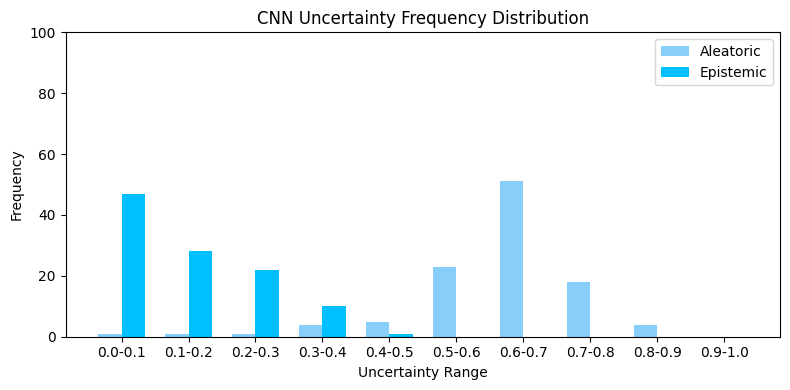

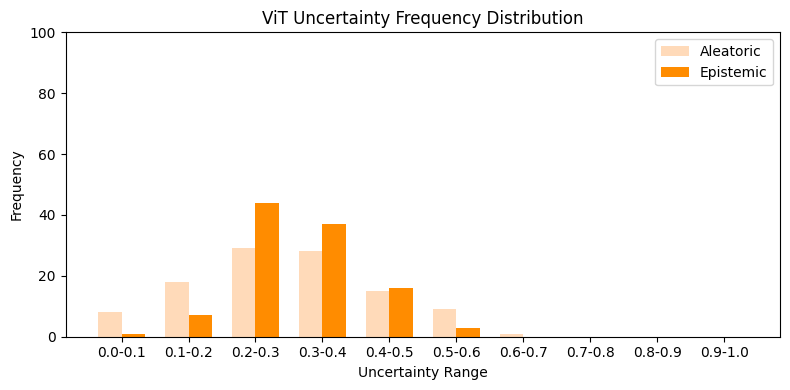

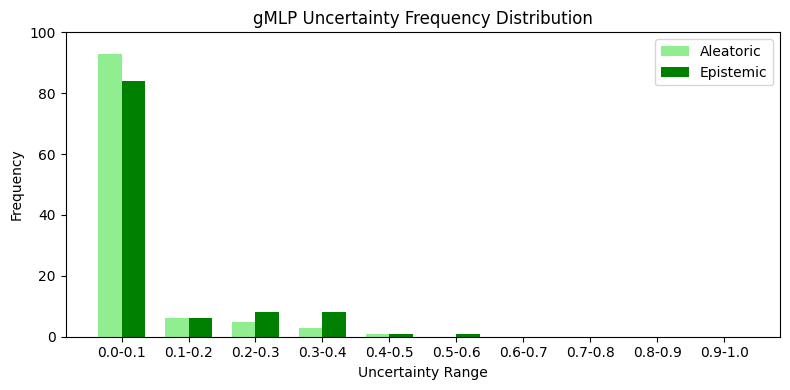

In [ ]:
bins = np.arange(0, 1.1, 0.1)

CNN_aleatoric_freq, _ = np.histogram(CNN_aleatoric, bins=bins)
ViT_aleatoric_freq, _ = np.histogram(ViT_aleatoric, bins=bins)
gMLP_aleatoric_freq, _ = np.histogram(gMLP_aleatoric, bins=bins)
CNN_epistemic_freq, _ = np.histogram(CNN_epistemic, bins=bins)
ViT_epistemic_freq, _ = np.histogram(ViT_epistemic, bins=bins)
gMLP_epistemic_freq, _ = np.histogram(gMLP_epistemic, bins=bins)

x = np.arange(len(bins) - 1)
width = 0.35
ylim = 100

# CNN Plot
plt.figure(figsize=(8, 4))
plt.bar(x - width/2, CNN_aleatoric_freq, width=width, label='Aleatoric', color='lightskyblue')
plt.bar(x + width/2, CNN_epistemic_freq, width=width, label='Epistemic', color='deepskyblue')
plt.title('CNN Uncertainty Frequency Distribution')
plt.xlabel('Uncertainty Range')
plt.ylabel('Frequency')
plt.xticks(x, [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins) - 1)])
plt.ylim(0, ylim)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ViT Plot
plt.figure(figsize=(8, 4))
plt.bar(x - width/2, ViT_aleatoric_freq, width=width, label='Aleatoric', color='peachpuff')
plt.bar(x + width/2, ViT_epistemic_freq, width=width, label='Epistemic', color='darkorange')
plt.title('ViT Uncertainty Frequency Distribution')
plt.xlabel('Uncertainty Range')
plt.ylabel('Frequency')
plt.xticks(x, [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins) - 1)])
plt.ylim(0, ylim)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# gMLP Plot
plt.figure(figsize=(8, 4))
plt.bar(x - width/2, gMLP_aleatoric_freq, width=width, label='Aleatoric', color='lightgreen')
plt.bar(x + width/2, gMLP_epistemic_freq, width=width, label='Epistemic', color='green')
plt.title('gMLP Uncertainty Frequency Distribution')
plt.xlabel('Uncertainty Range')
plt.ylabel('Frequency')
plt.xticks(x, [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins) - 1)])
plt.ylim(0, ylim)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()